# <center>Application of Time Series Forecasting in Real Estate Valuation </center>
## <center> Notebook 2: Static Modeling for Producing Time Series</center>



### Notebook Content:

<a href='#Destination_1'>1. Import Libraries</a><br>

<a href='#Destination_2'>2. Data Preping</a>

<a href='#Destination_3'>3. Quarterly Static Modeling </a><br>

<a href='#Destination_4'>4. LSTM Time Series Modeling</a><br>

<a href='#Destination_5'>5. Conclusion </a><br>

#### The approach in a nutshell
We will produce static models for every quarter of every year. Then predict the price of an instance, using all quarter models. The result is a predicted time series which will then be forecasted into the future using an LSTM. It should be noted that the timestamps ['Year','Quarter'] are not features in this approach. 


<a id='Destination_1'></a>
## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score
from sklearn.cluster import DBSCAN
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns

%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id='Destination_2'></a>
# 2. Data Preping
 - read the dataframe
 - Map the discrete features ['Type', 'CityPlanning', 'DistrictName'] into integeres (the mapping better be in ascending order based on the average price associated with each categorical value)
 - split the data into 80% train and 20% test sets .

In [3]:
df = pd.read_csv('./Data_Frame.csv').dropna(how='any',axis=0)
display(df.head())
df.shape

,TradePrice,Area,MinTimeToNearestStation,HousingCPI,DistrictAvgPriceByQuarter,CityPlanningAvgPriceByQuarter,AreaAvgPriceByQuarter,MinTimeAvgPriceByQuarter,Year,Quarter,Type,CityPlanning,DistrictName
0,40000000,30,4.0,99.8,3.200000e+07,3.267775e+07,2.590896e+07,3.479964e+07,2019,3,"Pre-owned Condominiums, etc.",Commercial Zone,Iidabashi
1,24000000,35,3.0,99.6,3.900000e+07,3.204836e+07,2.786471e+07,3.632381e+07,2018,4,"Pre-owned Condominiums, etc.",Commercial Zone,Iidabashi
2,13000000,20,4.0,99.6,1.933333e+07,3.299709e+07,2.023154e+07,3.766148e+07,2018,3,"Pre-owned Condominiums, etc.",Commercial Zone,Iidabashi
3,22000000,30,3.0,99.6,4.825000e+07,3.350125e+07,2.710536e+07,3.573333e+07,2018,2,"Pre-owned Condominiums, etc.",Commercial Zone,Iidabashi
4,69000000,70,1.0,99.6,4.825000e+07,3.350125e+07,4.549386e+07,3.516614e+07,2018,2,"Pre-owned Condominiums, etc.",Commercial Zone,Iidabashi


(328249, 13)

In [5]:
cols = list(df)

#initialize
discrete_featues = pd.DataFrame(df[cols[10:]], columns = cols[10:])
mapping_indecies = {}
# loop over discrete features to map 
for feat in cols[10:]:

    # sort discrete values based on their average tradeprice
    sorted_indecies = pd.Series({value : df['TradePrice'].loc[df[feat]==value].mean()
                                     for value in df[feat].unique()}).sort_values().index
    # save mapping_indecies
    mapping_indecies[feat]=sorted_indecies
    # map each index to an integer i, remeber indecies here are the discrete values a feature
    for i, index in enumerate(sorted_indecies):
        discrete_featues[feat].loc[discrete_featues[feat]==index]= i+1 #start from i=1  
        

In [6]:
data_df = pd.concat([df[cols[:10]],discrete_featues],axis=1)
display(data_df.head())
data_df.shape

,TradePrice,Area,MinTimeToNearestStation,HousingCPI,DistrictAvgPriceByQuarter,CityPlanningAvgPriceByQuarter,AreaAvgPriceByQuarter,MinTimeAvgPriceByQuarter,Year,Quarter,Type,CityPlanning,DistrictName
0,40000000,30,4.0,99.8,3.200000e+07,3.267775e+07,2.590896e+07,3.479964e+07,2019,3,1,4,1195
1,24000000,35,3.0,99.6,3.900000e+07,3.204836e+07,2.786471e+07,3.626380e+07,2018,4,1,4,1195
2,13000000,20,4.0,99.6,1.933333e+07,3.299709e+07,2.023404e+07,3.763182e+07,2018,3,1,4,1195
3,22000000,30,3.0,99.6,4.825000e+07,3.350125e+07,2.710536e+07,3.573333e+07,2018,2,1,4,1195
4,69000000,70,1.0,99.6,4.825000e+07,3.350125e+07,4.549386e+07,3.516614e+07,2018,2,1,4,1195


(328612, 13)

In [7]:
# train/test split
cols = data_df.columns
X_data = data_df[cols[1:]].values
y_data = data_df[cols[0]].values

X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, train_size = 0.8, shuffle=True, random_state = 34)

train_df = pd.DataFrame(np.concatenate((y_train.reshape(len(y_train),1),X_train),axis=1), columns = cols)
test_df = pd.DataFrame(np.concatenate((y_test.reshape(len(y_test),1),X_test),axis=1), columns = cols)

display(train_df.head())
display(train_df.shape)
display(test_df.head())
display(test_df.shape)

,TradePrice,Area,MinTimeToNearestStation,HousingCPI,DistrictAvgPriceByQuarter,CityPlanningAvgPriceByQuarter,AreaAvgPriceByQuarter,MinTimeAvgPriceByQuarter,Year,Quarter,Type,CityPlanning,DistrictName
0,44000000,80,18.0,101.3,38636363.636364,42667959.731544,39573604.060914,34358441.558442,2009,3,1,15,1191
1,8000000,20,6.0,100.933333,24228571.428571,26707692.307692,15864794.520548,38239967.479675,2010,2,1,4,348
2,31000000,75,6.0,100.3,30000000.0,28047301.006404,39842993.197279,34070389.170897,2012,3,1,4,684
3,69000000,240,15.0,99.9,39000000.0,36282990.825688,62017857.142857,33576829.268293,2013,3,2,12,1031
4,39000000,160,16.0,101.333333,37600000.0,46147207.155026,55045454.545455,40318181.818182,2007,4,3,15,1055


(262889, 13)

,TradePrice,Area,MinTimeToNearestStation,HousingCPI,DistrictAvgPriceByQuarter,CityPlanningAvgPriceByQuarter,AreaAvgPriceByQuarter,MinTimeAvgPriceByQuarter,Year,Quarter,Type,CityPlanning,DistrictName
0,32000000,50,3.0,99.7,36100000.0,33552446.48318,35419112.627986,33980235.294118,2019,2,1,5,817
1,41000000,80,9.0,99.8,53250000.0,34363333.333333,44221757.322176,36968043.478261,2014,1,2,13,1278
2,41000000,70,4.0,101.4,34266666.666667,37929577.464789,40013513.513514,34681609.195402,2008,1,1,12,748
3,55000000,100,10.0,101.033333,52250000.0,42910643.274854,43440217.391304,36673385.01292,2010,1,3,15,1007
4,5500000,15,6.0,99.7,18200000.0,32975518.672199,12375416.666667,37508225.806452,2017,3,1,5,518


(65723, 13)

<a id='Destination_3'></a>


# 3. Quarterly Static Modeling

### model every quarter and select best model for every quarter (using the training set).
- seperate the data into groups for every quarter of every year.
- define model pool for model selection.
- for evey group, run model selection (using 5 Kfolds) based on best mean RMSE performance.
- plot the 5 k-folds performance for qurater.
- record the votes for best model for every quarter.
- then elect candidate model based on majority vote of all quarters.
- produce a model for evey quarter, using the full training set (the algorithm used will be the candidate model)
- visualize the performance of the model of every quarter.


In [8]:
# seperate the data into groups and save them in a dictionary 
Quarterly_train_data = {}
Quarterly_test_data = {}
for year in np.sort(train_df['Year'].unique()):
    
    for quarter in np.sort(train_df['Quarter'].unique()):
        # select the data for the specific year and the specefic quarter
        temp_train_df = train_df.loc[train_df['Year']==year].loc[train_df['Quarter']==quarter].drop(['Year','Quarter'],axis=1).astype(float)
        temp_test_df = test_df.loc[test_df['Year']==year].loc[test_df['Quarter']==quarter].drop(['Year','Quarter'],axis=1).astype(float)
        # if temp_train_df is not empty (being empty happens with the first and last year because not all their quarters are available)
        if temp_train_df.shape[0]!=0:
            Quarterly_train_data[str(year)+'-'+str(quarter)] = temp_train_df
            Quarterly_test_data[str(year)+'-'+str(quarter)] = temp_test_df

#### define model pool for model selection.

In [7]:
# definition of mlp
def instantiate_mlp(shape):
    tf.random.set_seed(34) # govern the initial weights
    mlp = keras.Sequential(
        [
            layers.Input(shape=(shape[1],)),
            layers.Dense(256, name="H1", activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(128, name="H2", activation="relu"),
            layers.Dense(64, name="H3", activation="relu"),
            layers.Dense(32, name="H4", activation="relu"),
            layers.Dense(1, name="output", activation="relu")
        ]
    )

    mlp.compile(optimizer='adam', loss='mse', metrics=tf.keras.metrics.RootMeanSquaredError())
    return mlp

In [8]:
# defining the pool of models 
ml_pool = {
    
    'xgb': XGBRegressor(n_estimators=300,random_state=34),
    
    'adaboost': AdaBoostRegressor(n_estimators=300,random_state=34),
    
    'rf': RandomForestRegressor(n_estimators=300, max_features='log2',random_state=34),
    
    '3nn': KNeighborsRegressor(n_neighbors=3),
    '5nn': KNeighborsRegressor(n_neighbors=5),
    '10nn': KNeighborsRegressor(n_neighbors=10),

    'mlp': instantiate_mlp
}

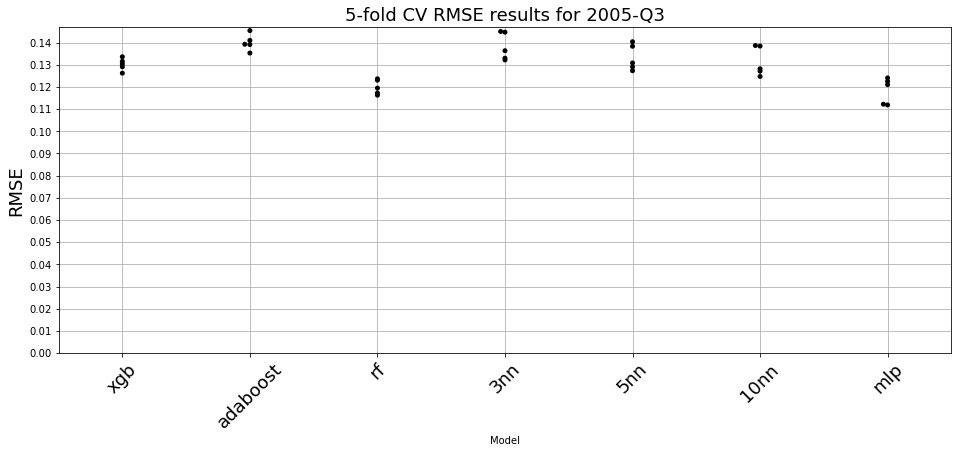

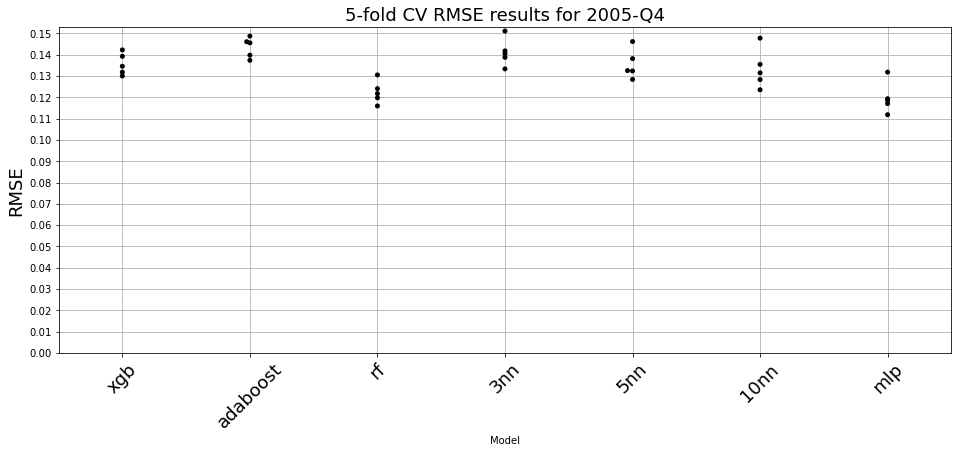

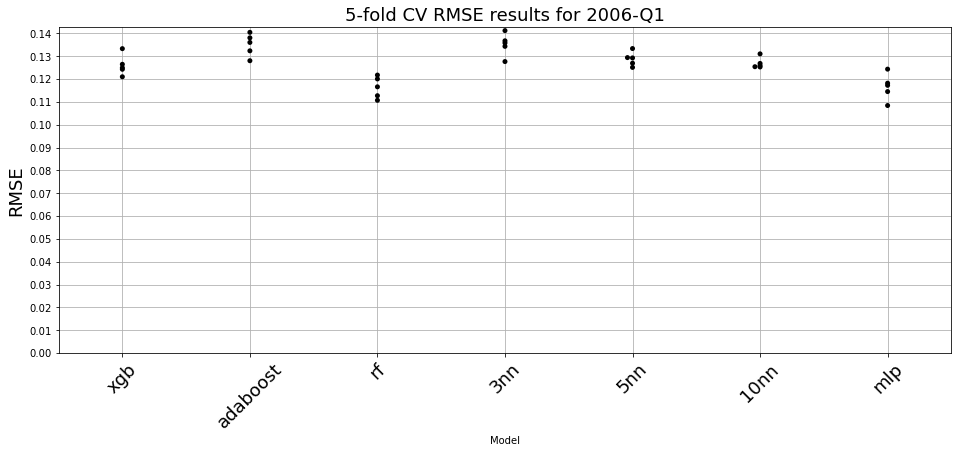

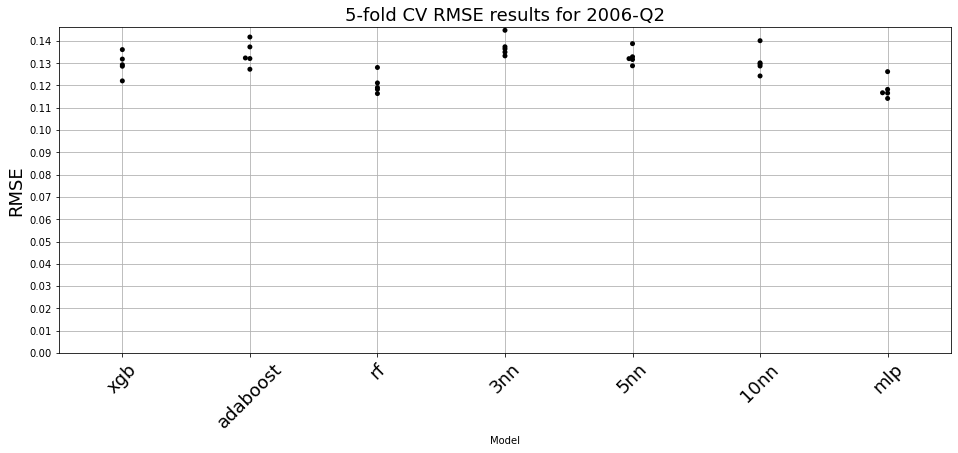

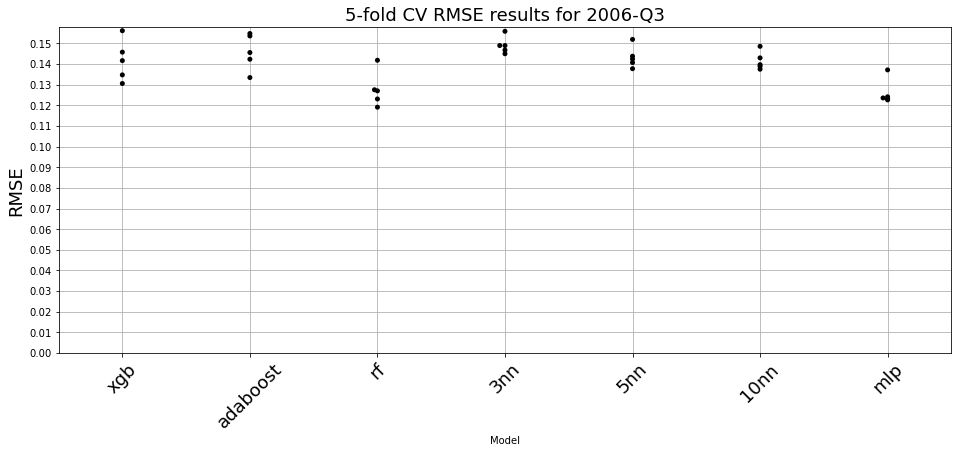

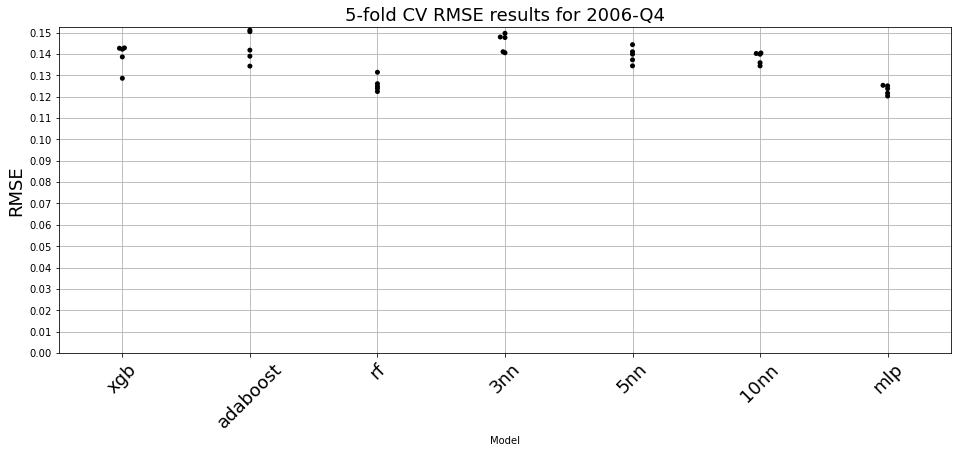

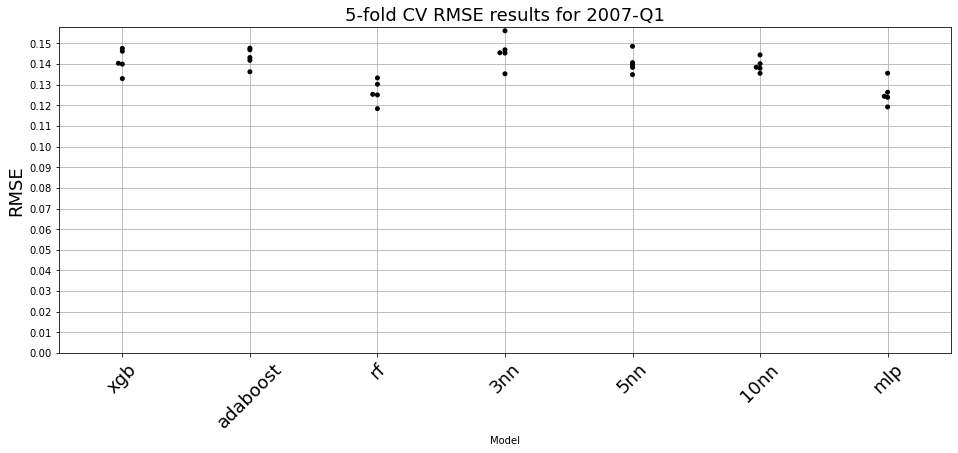

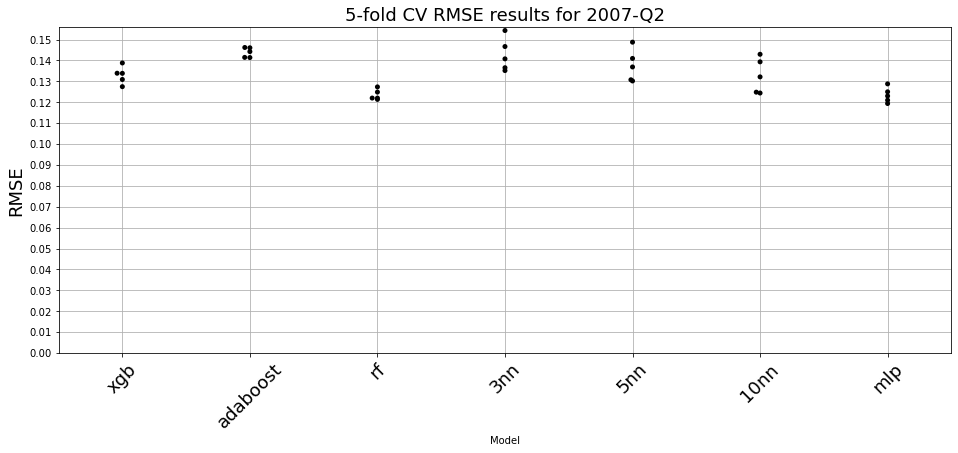

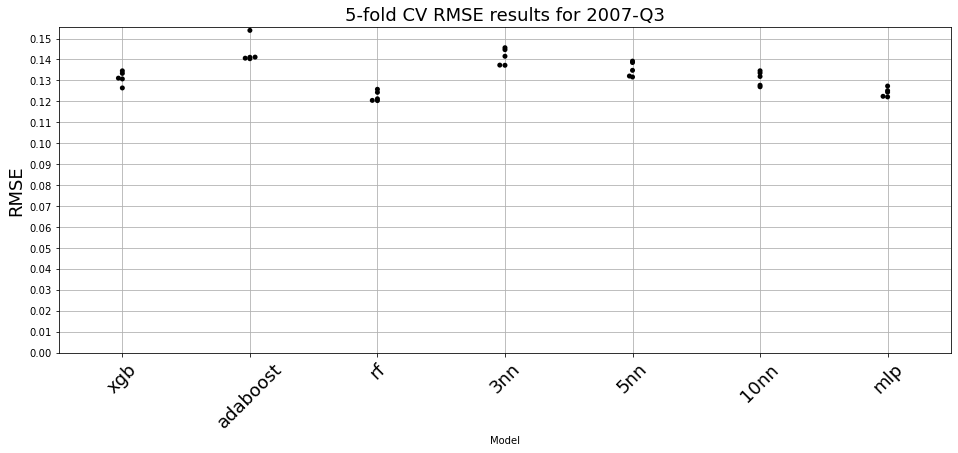

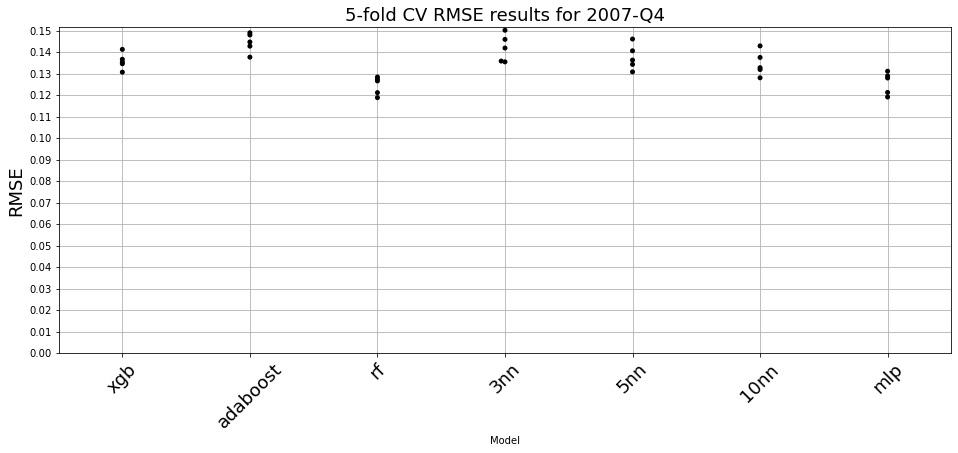

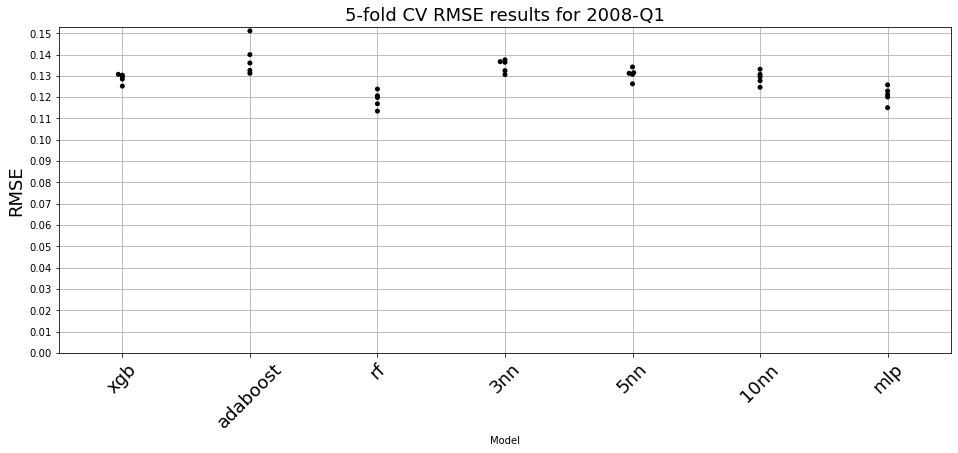

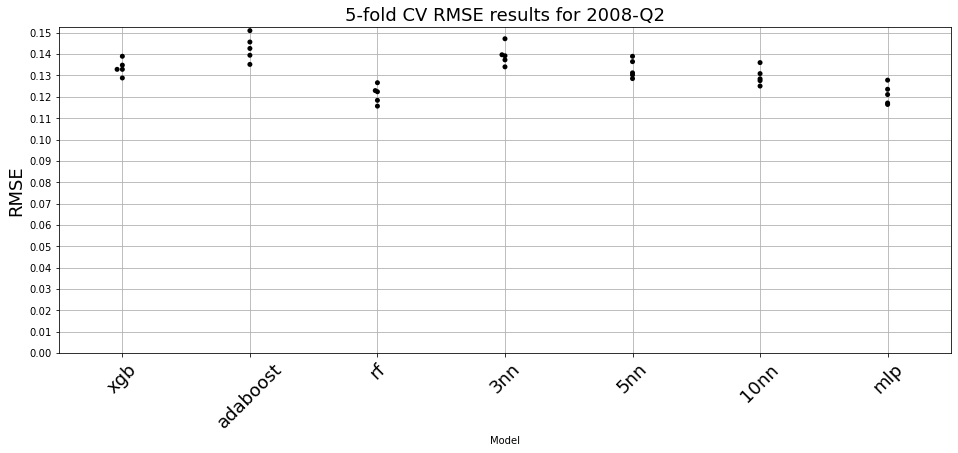

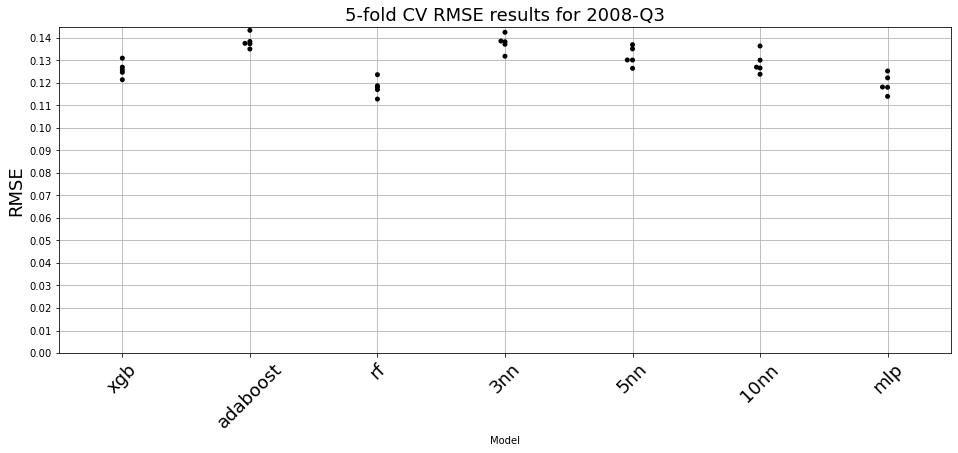

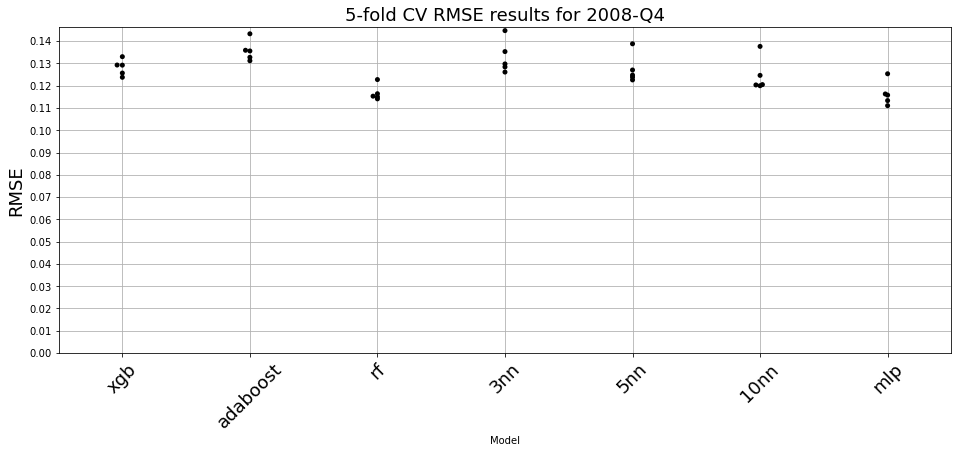

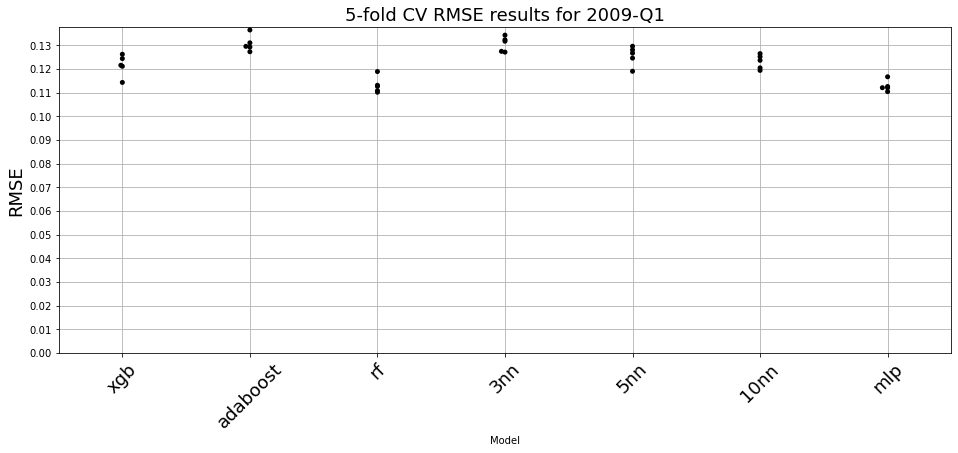

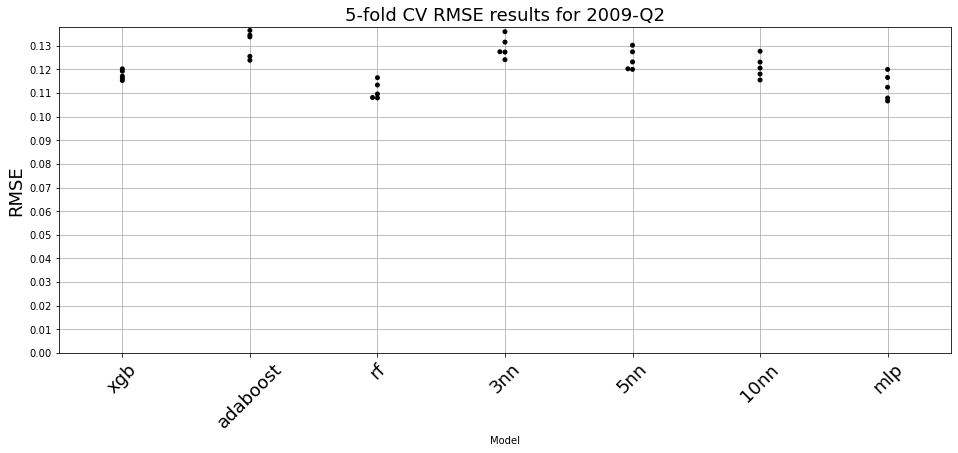

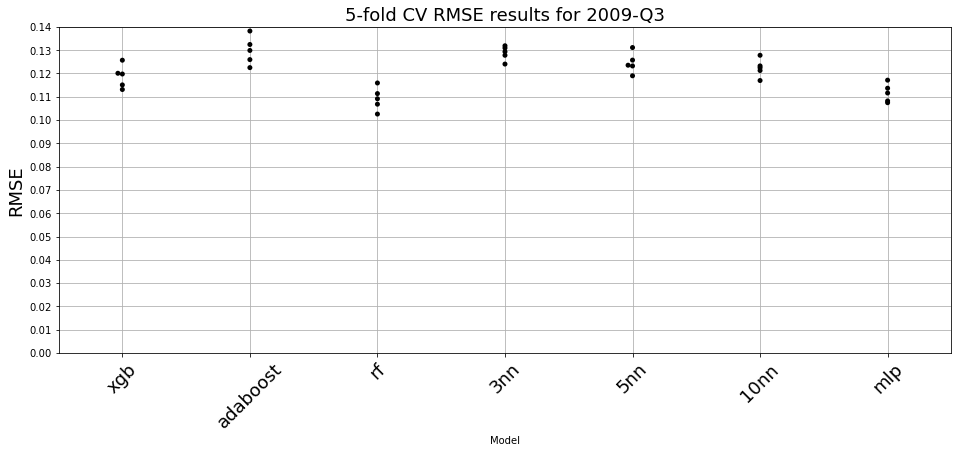

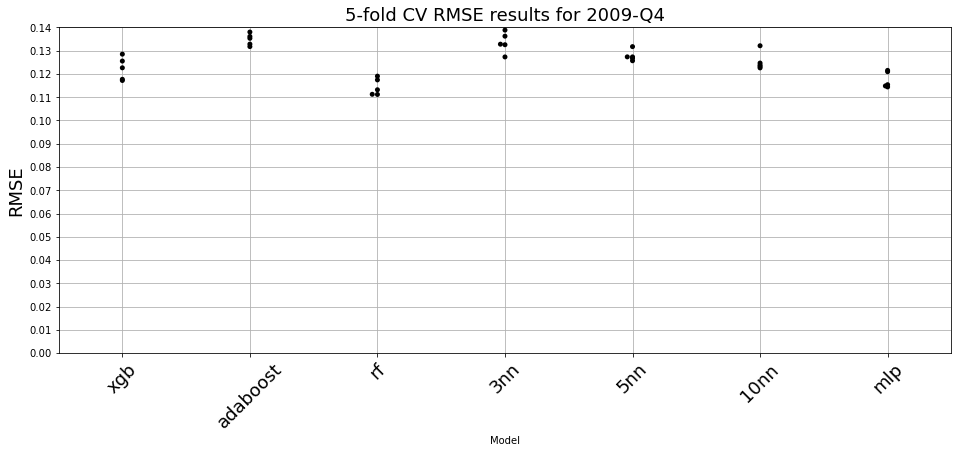

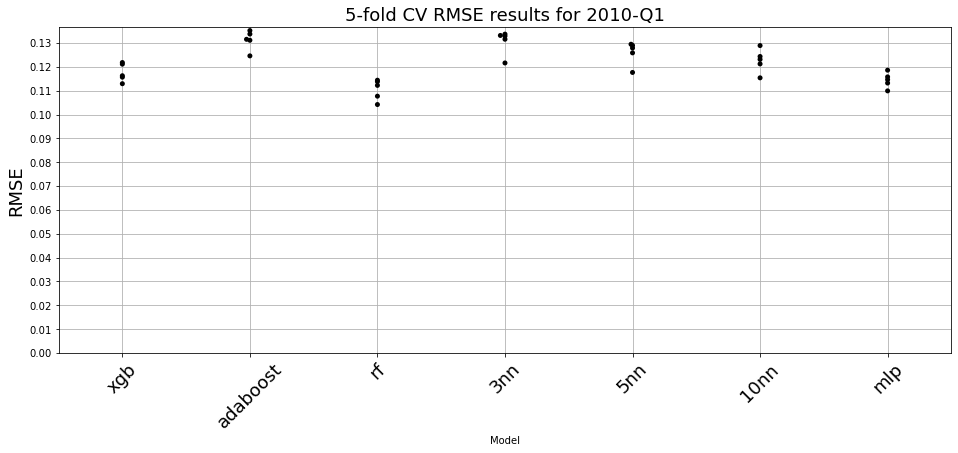

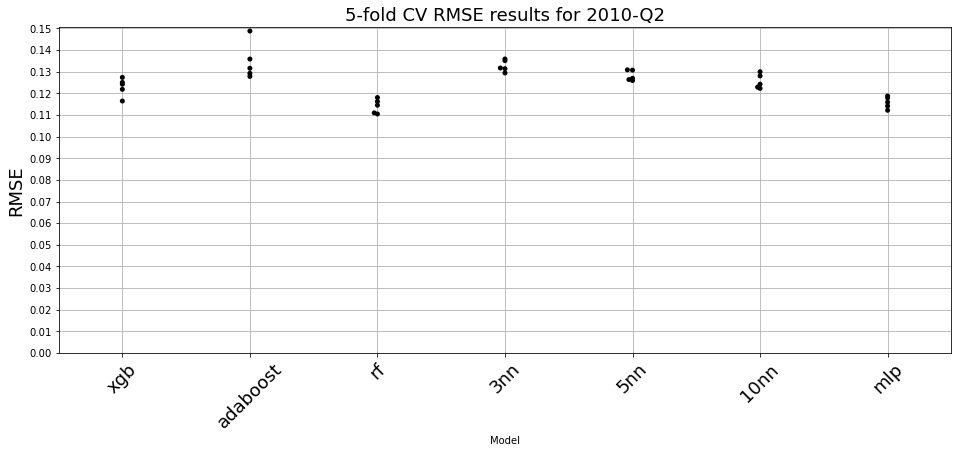

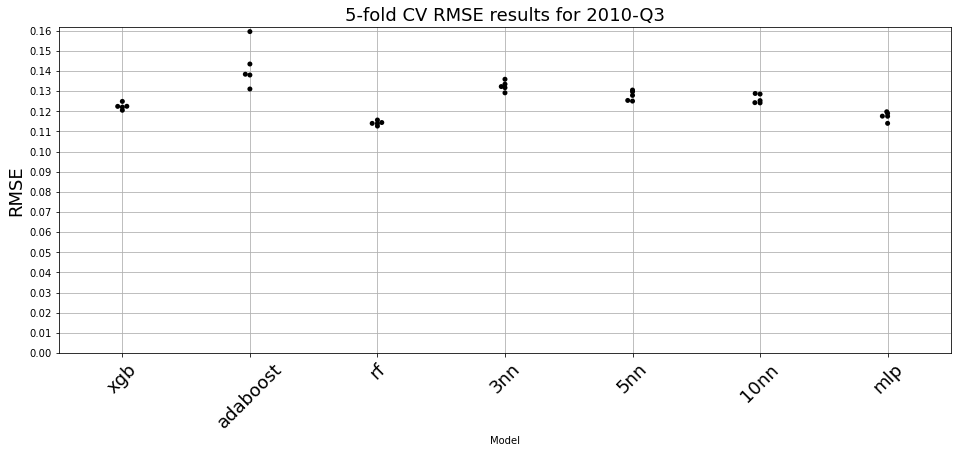

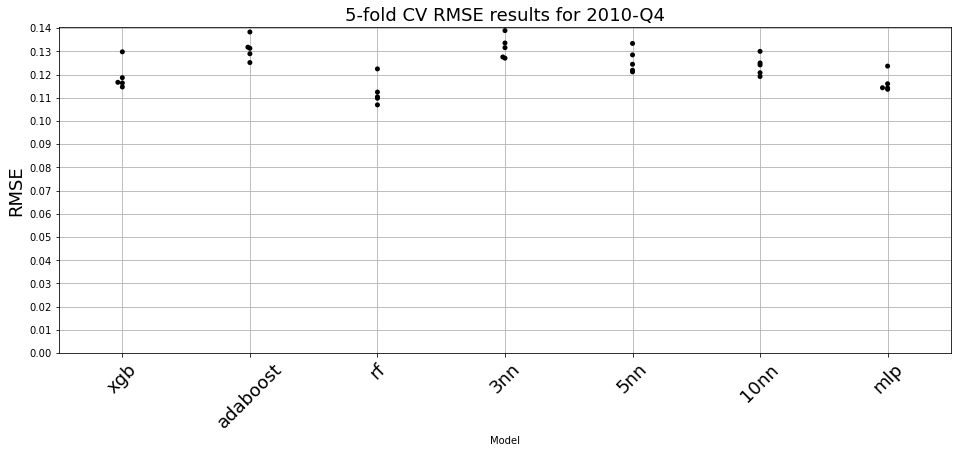

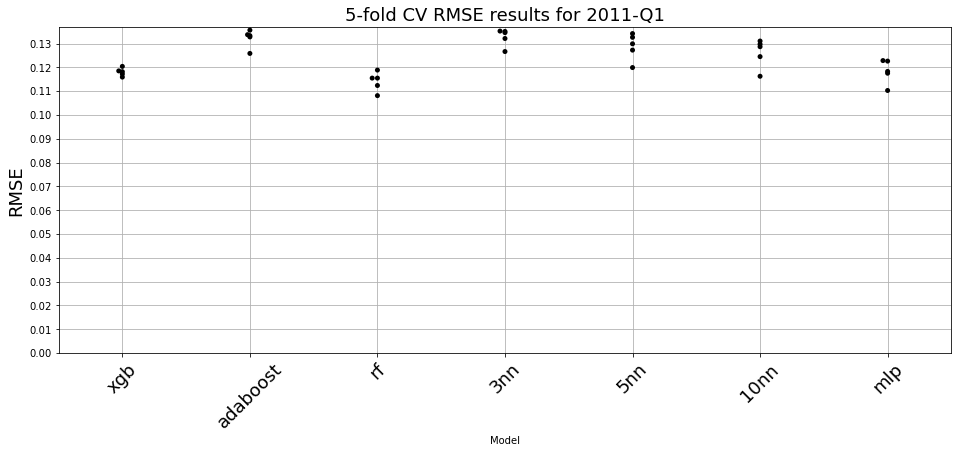

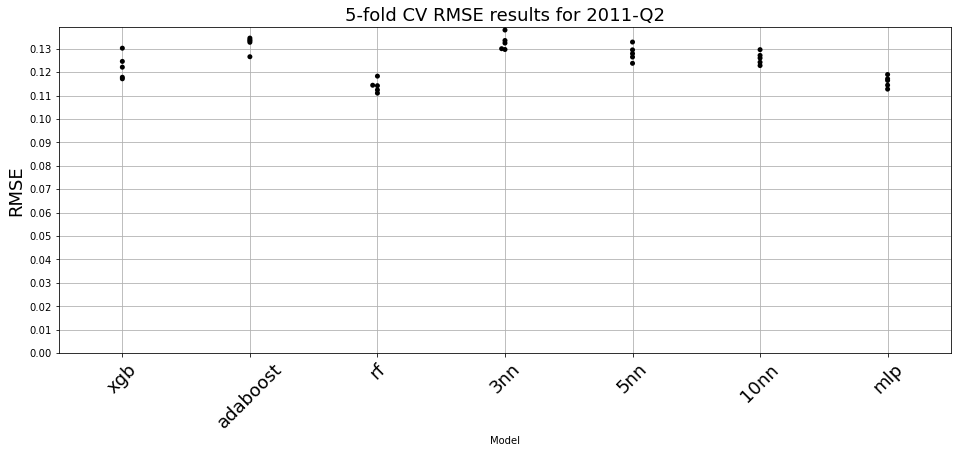

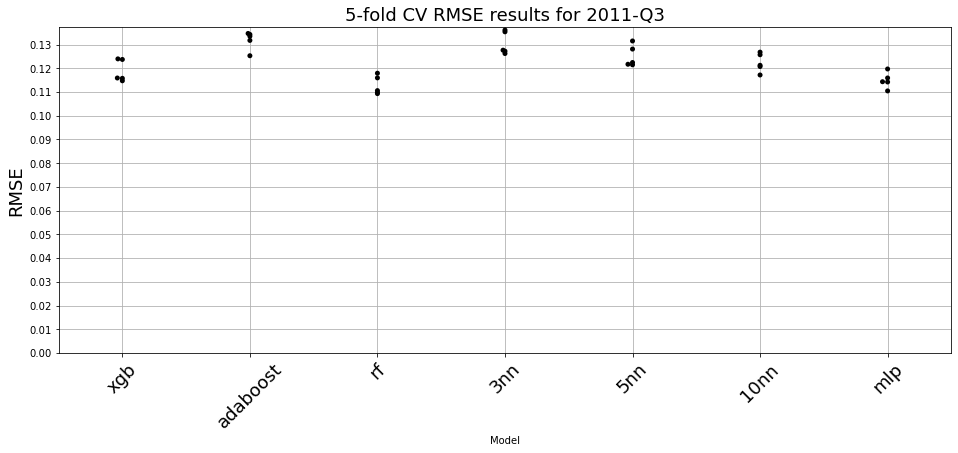

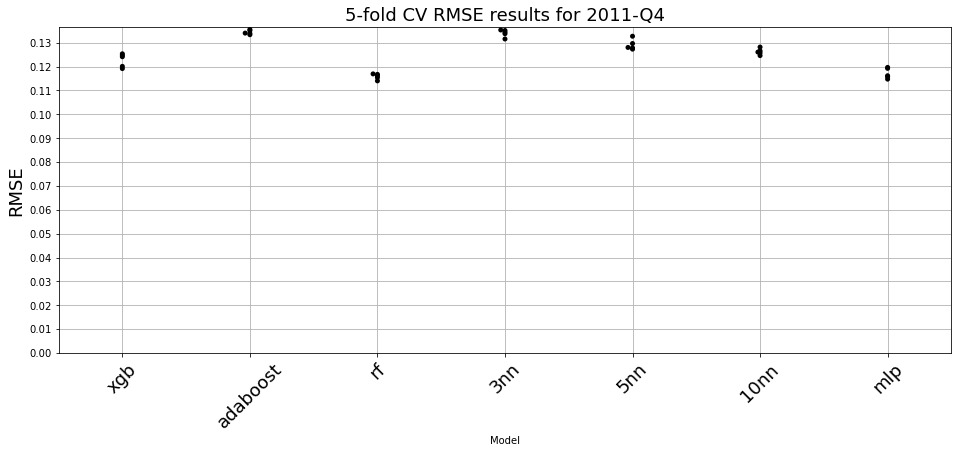

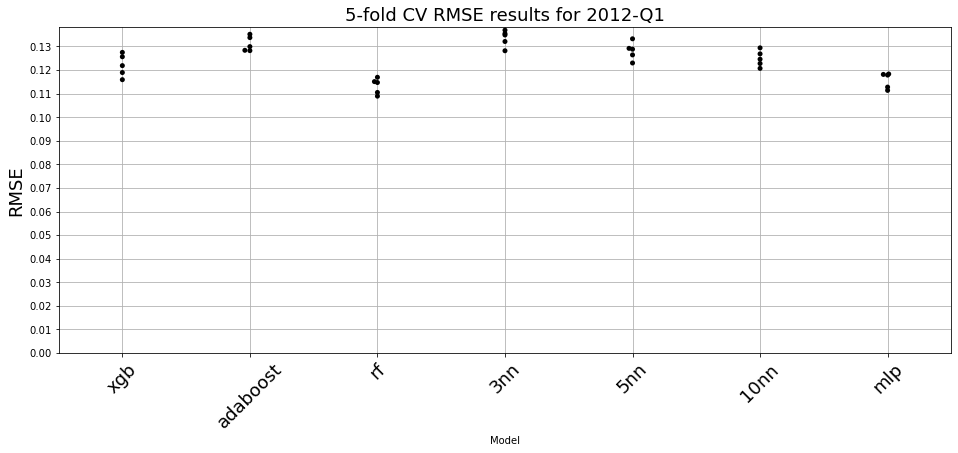

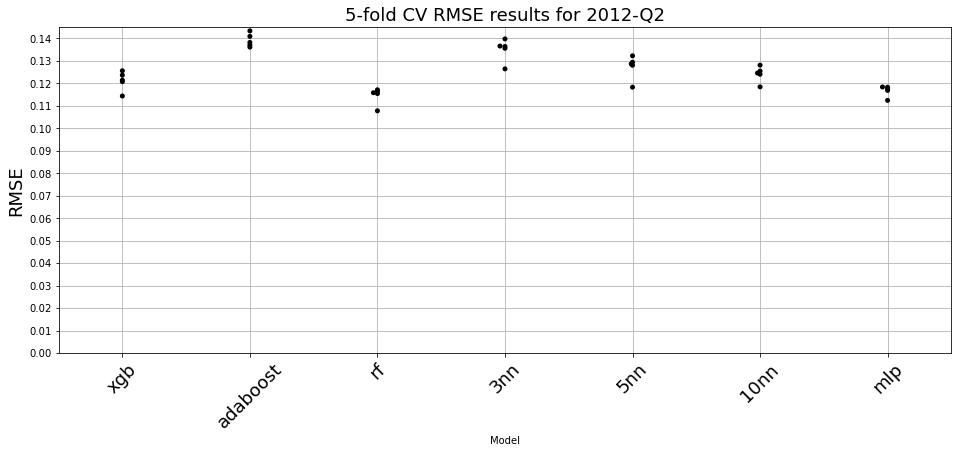

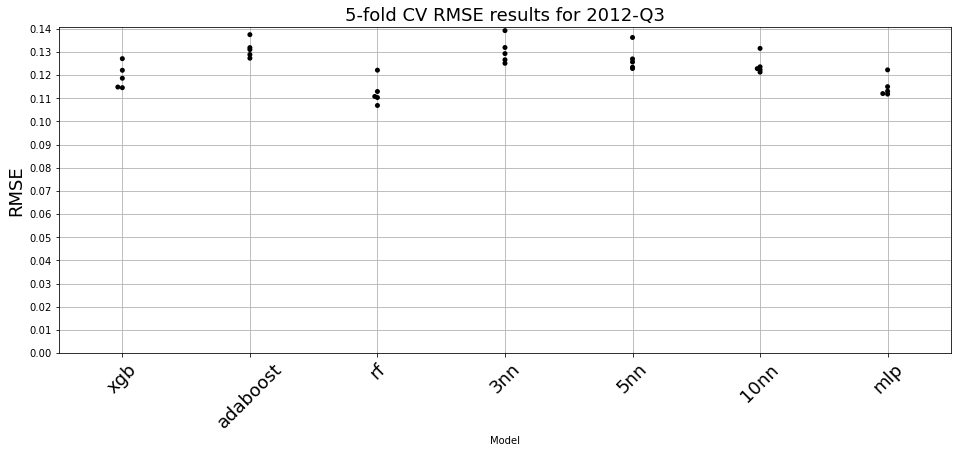

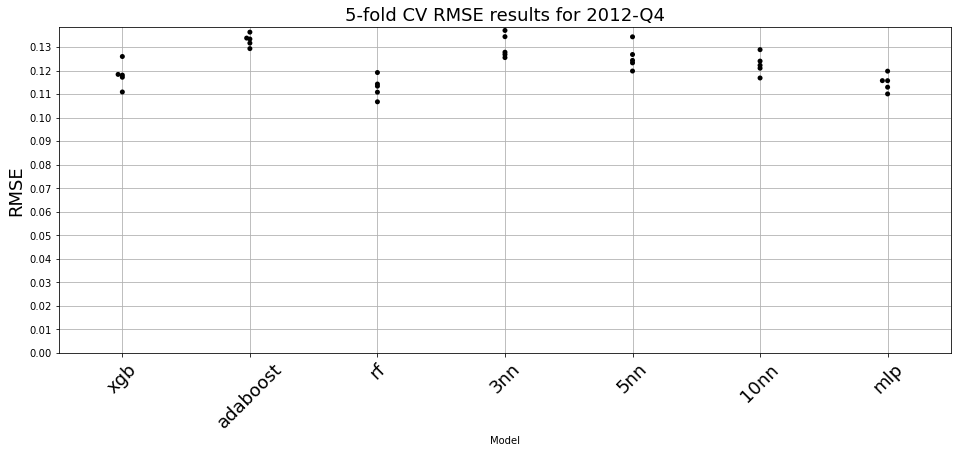

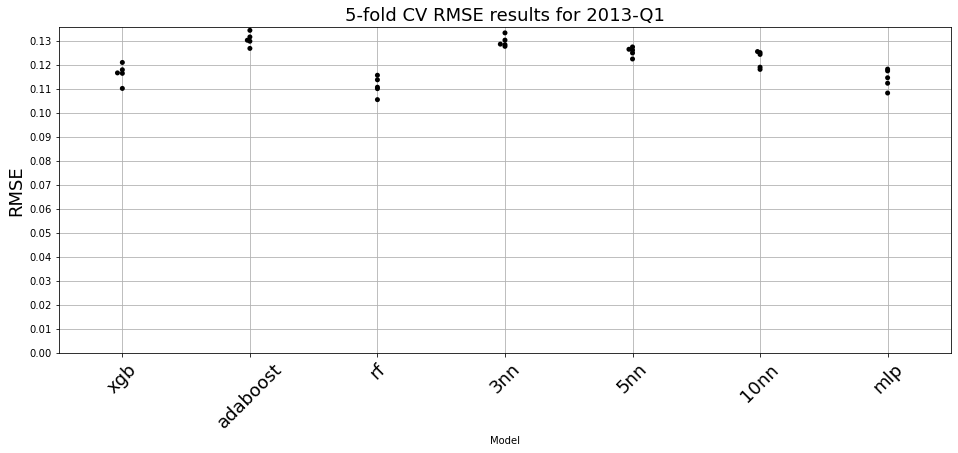

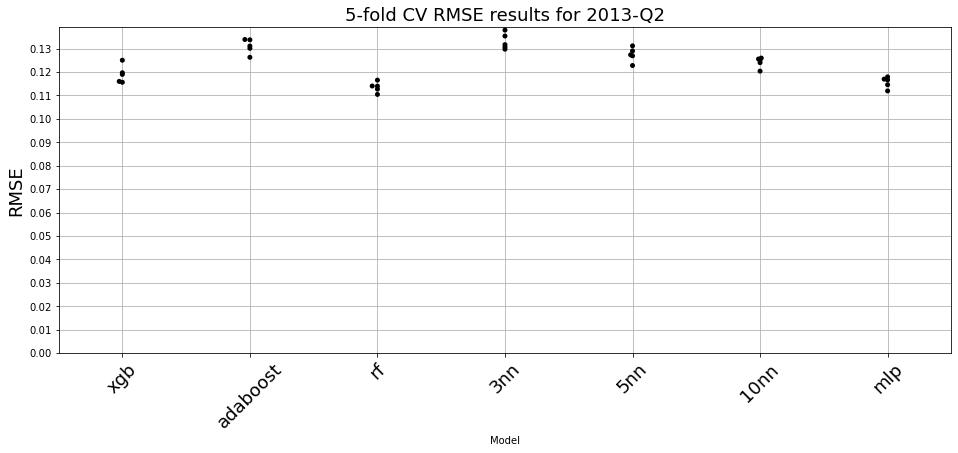

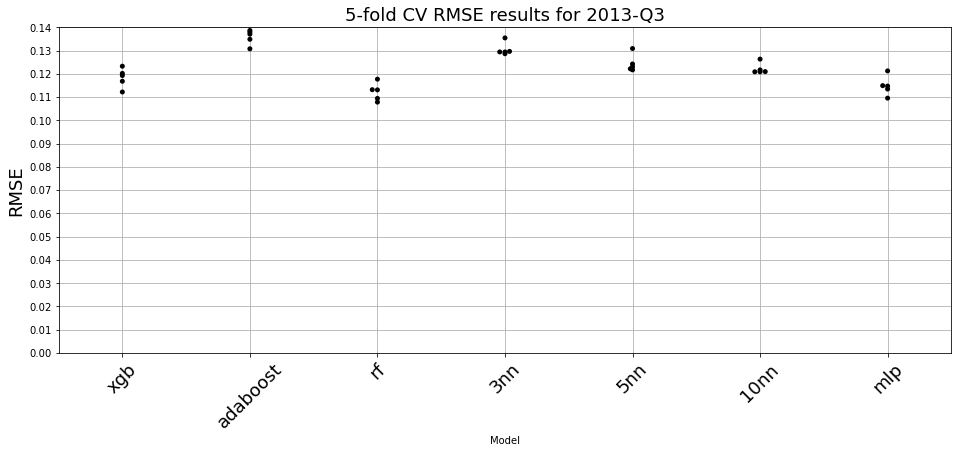

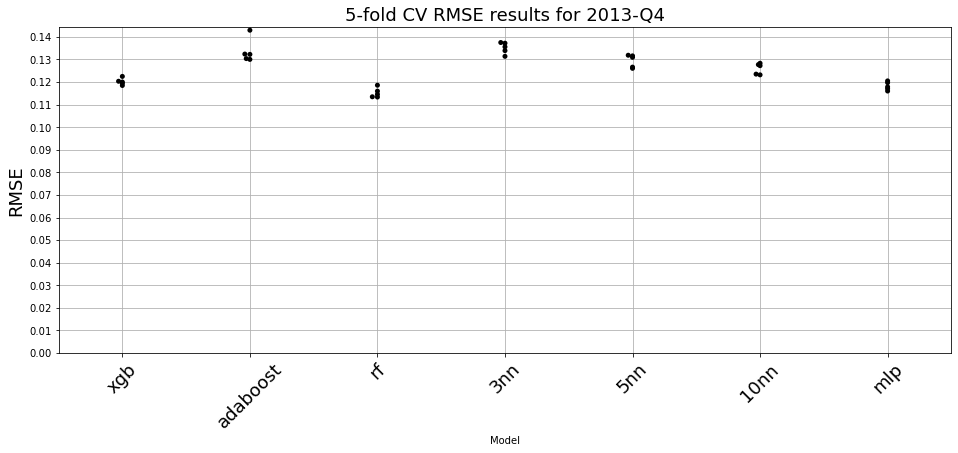

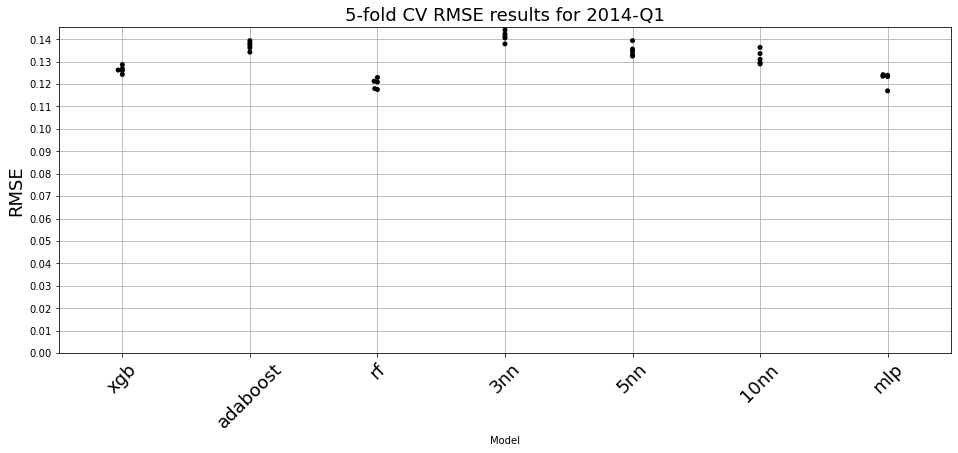

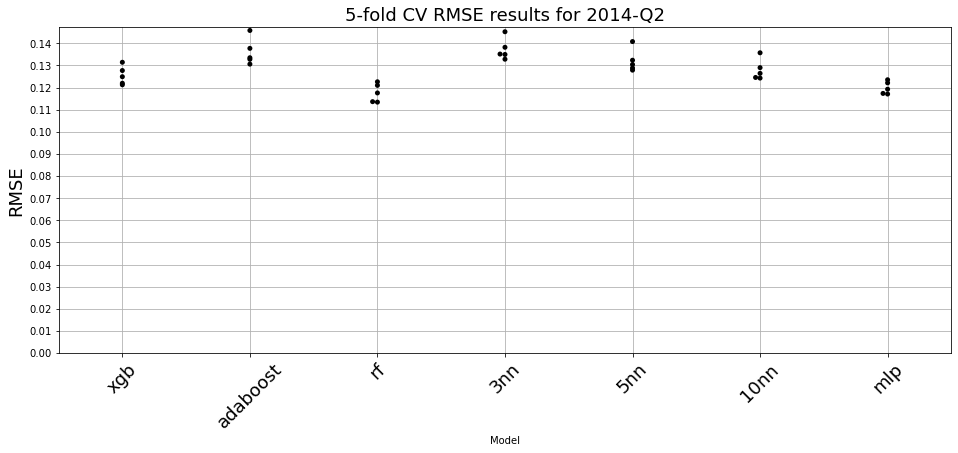

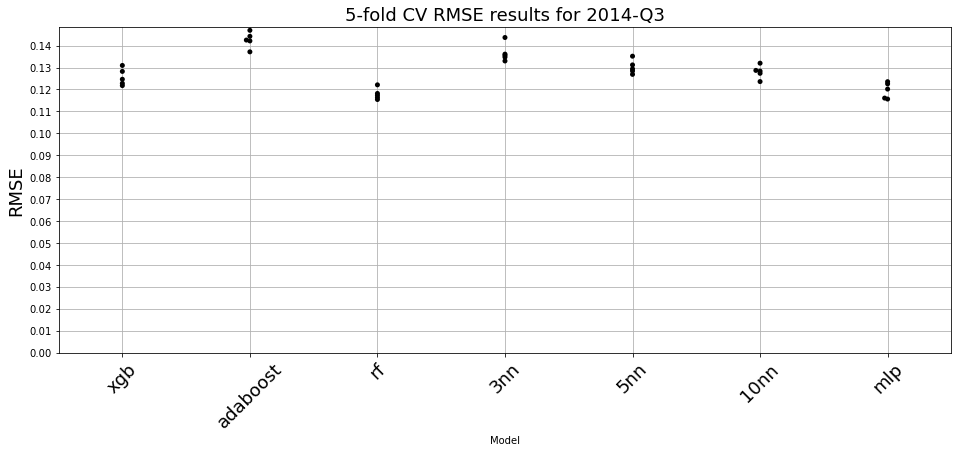

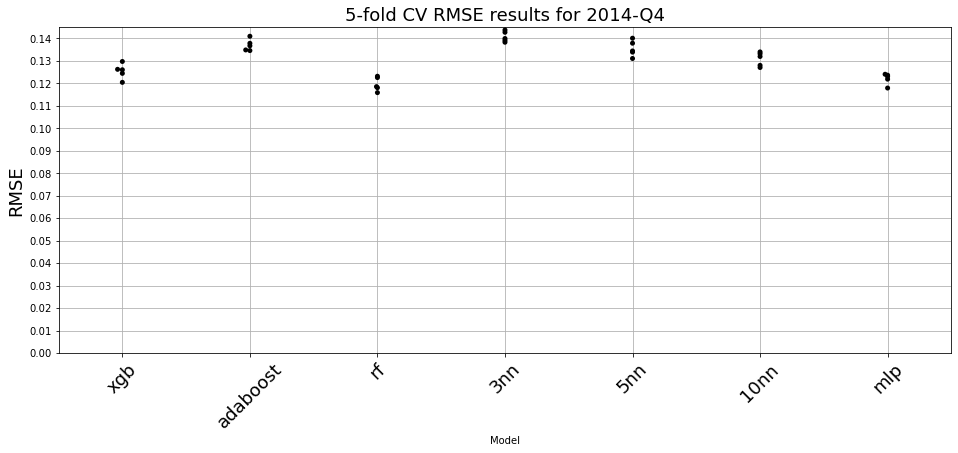

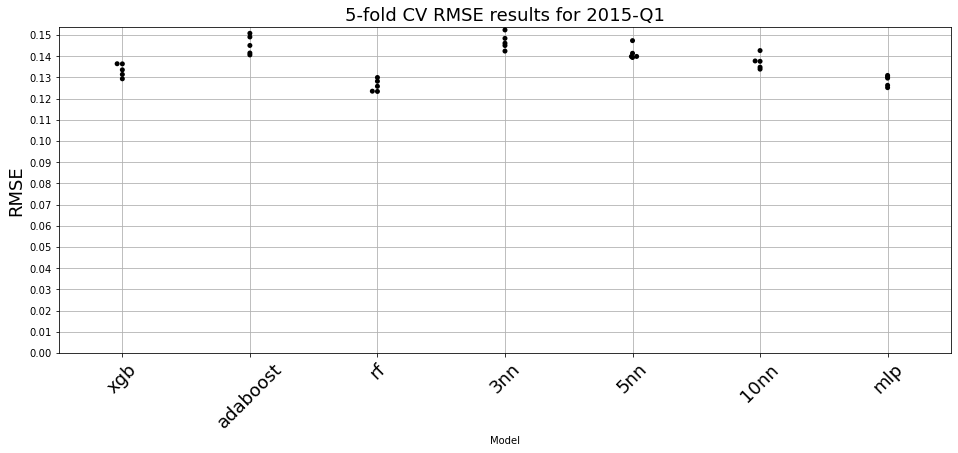

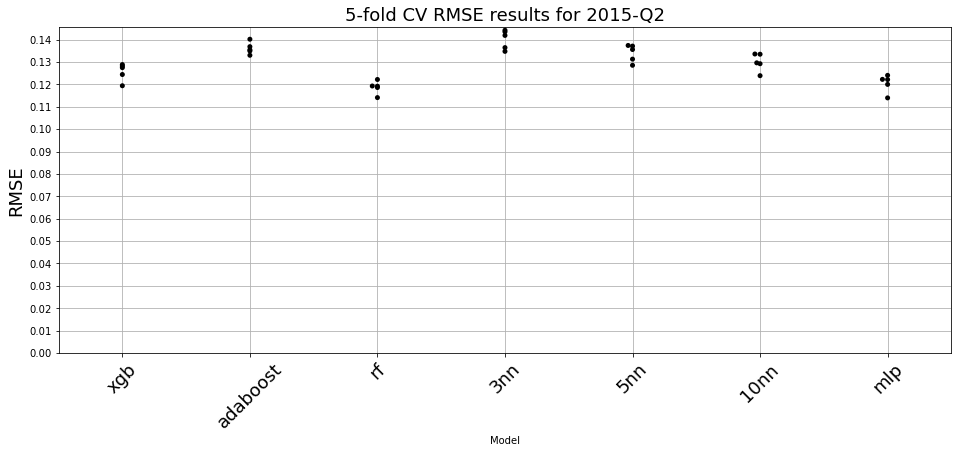

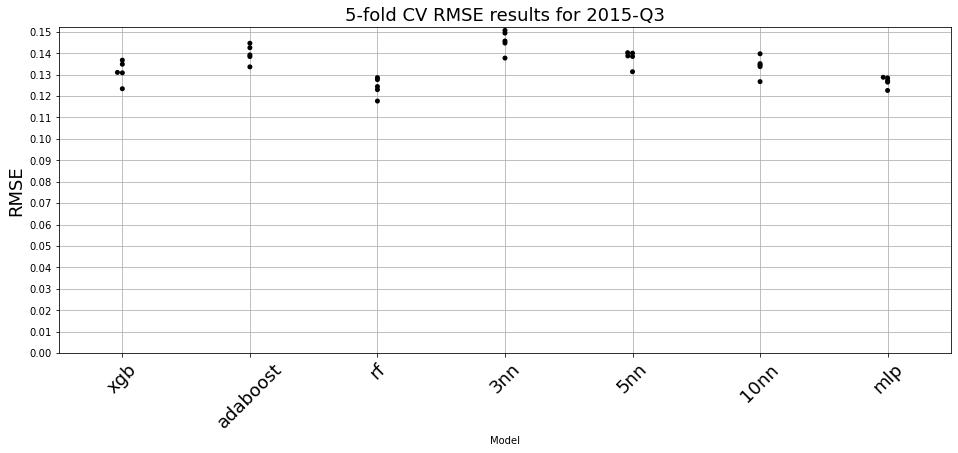

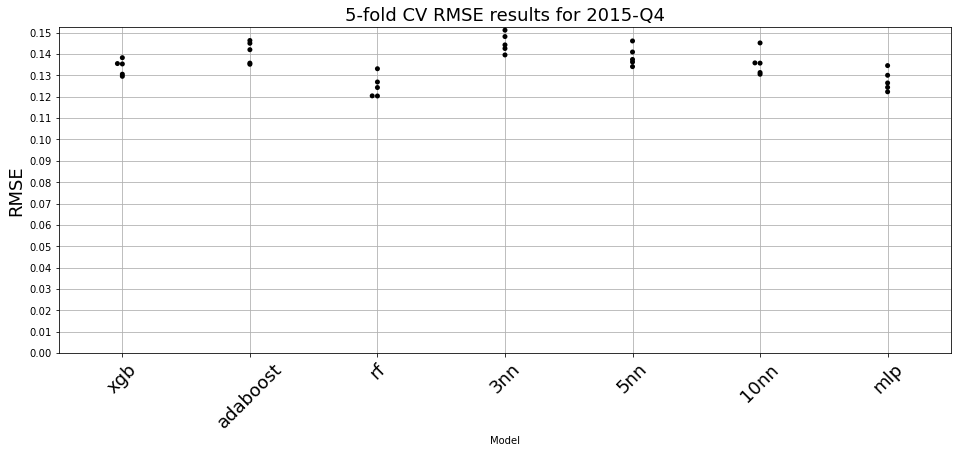

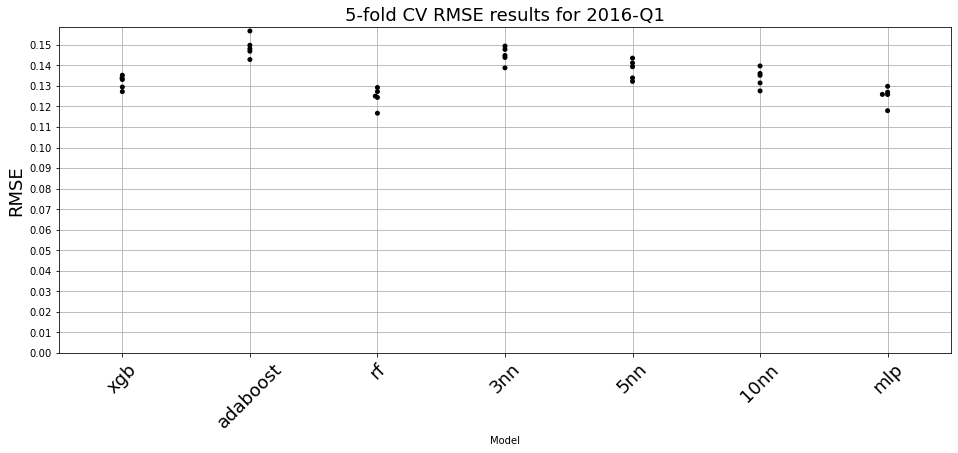

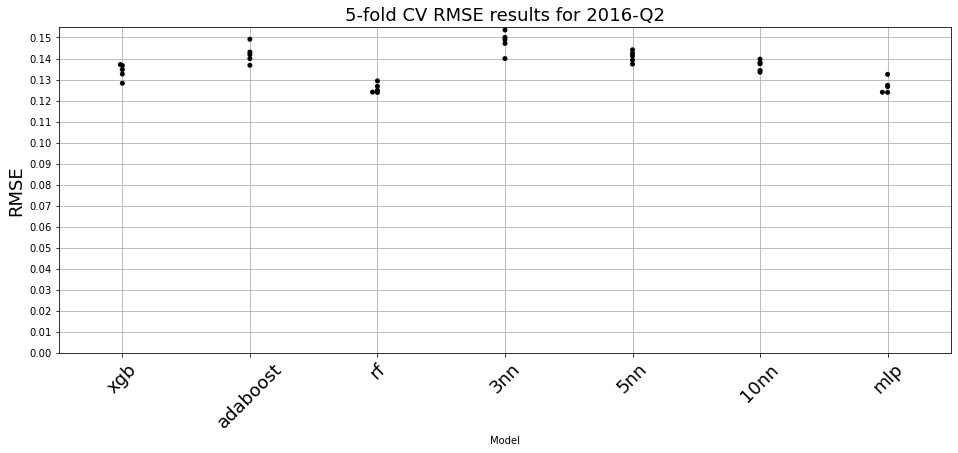

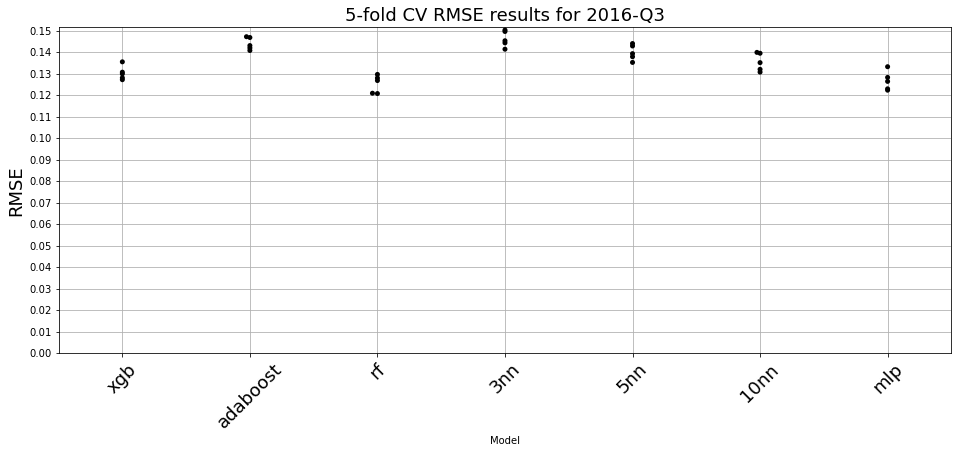

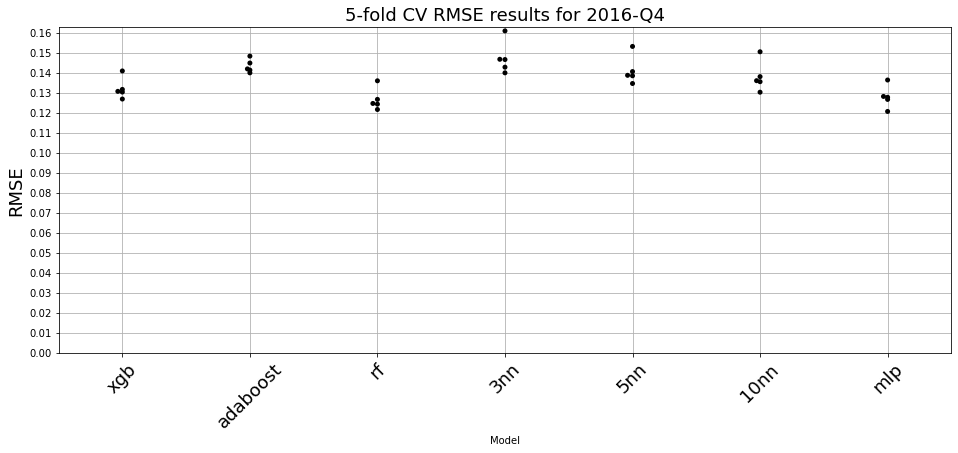

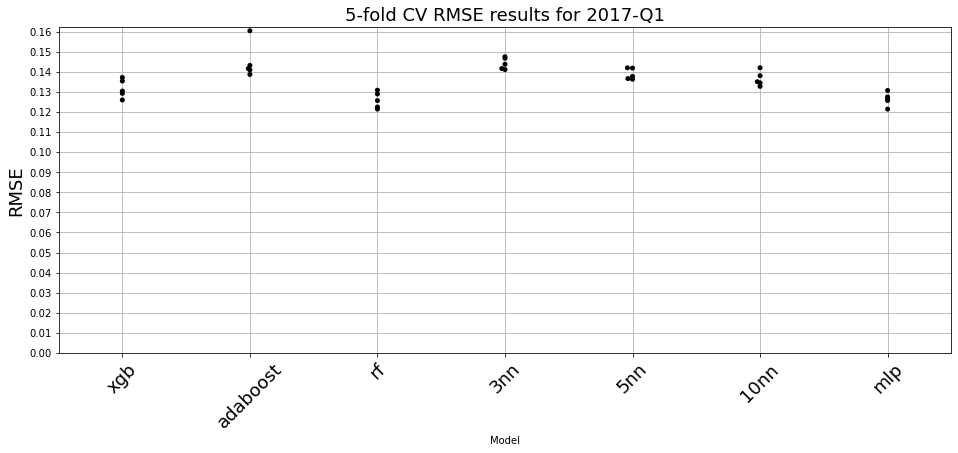

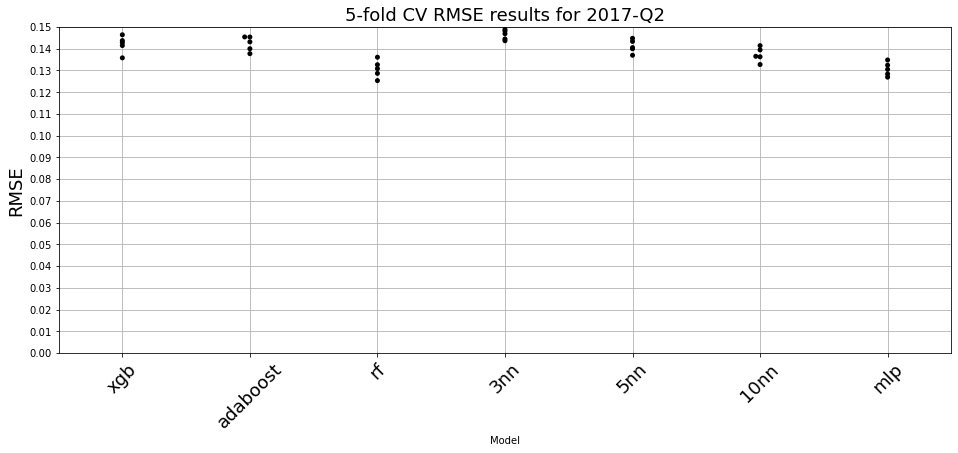

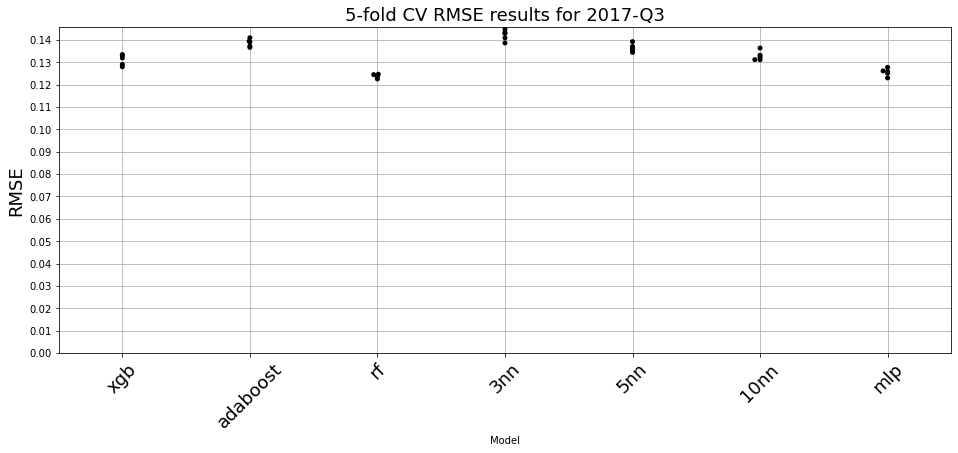

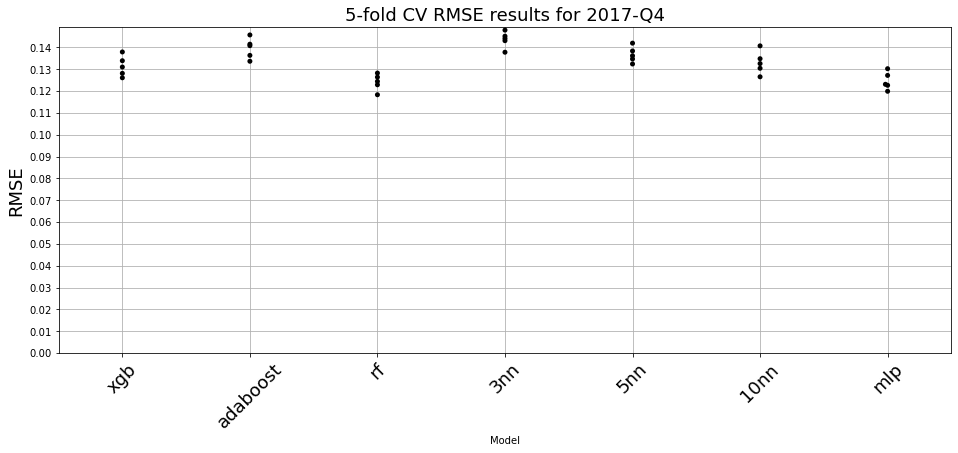

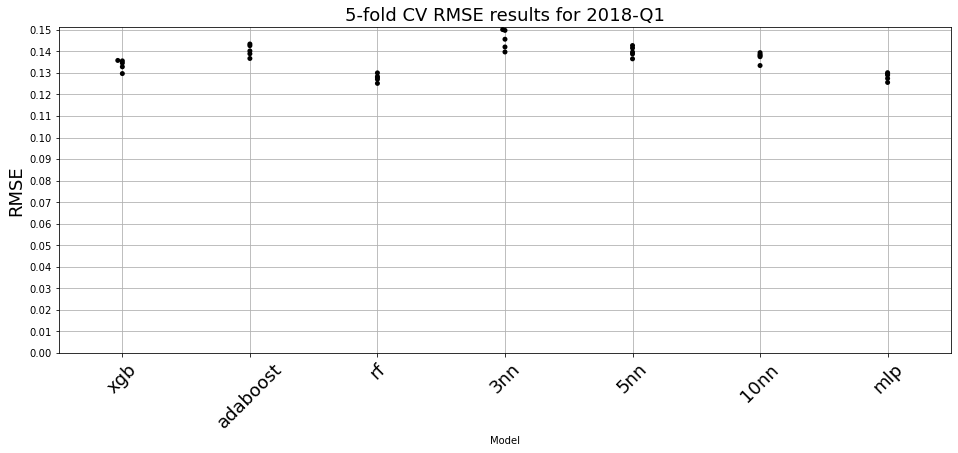

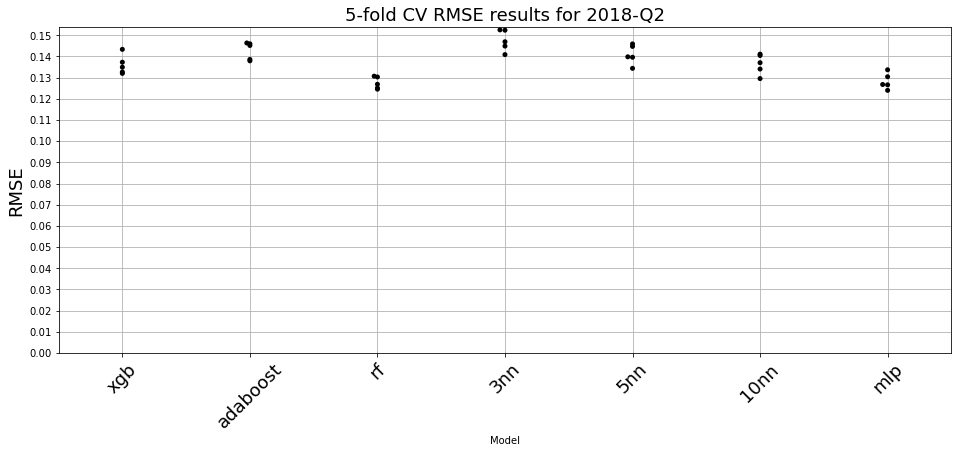

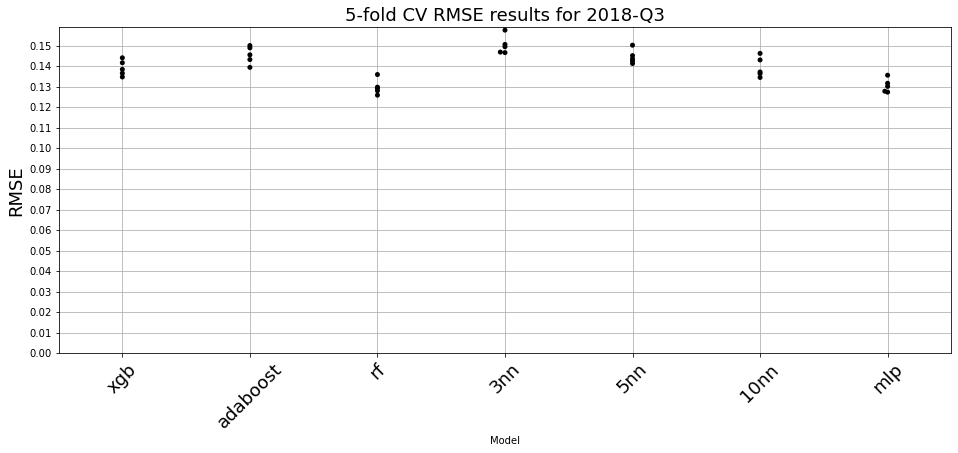

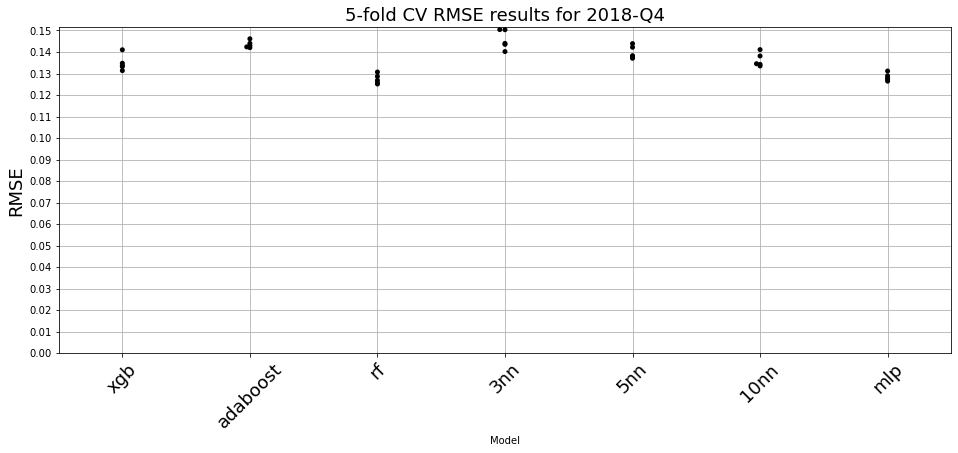

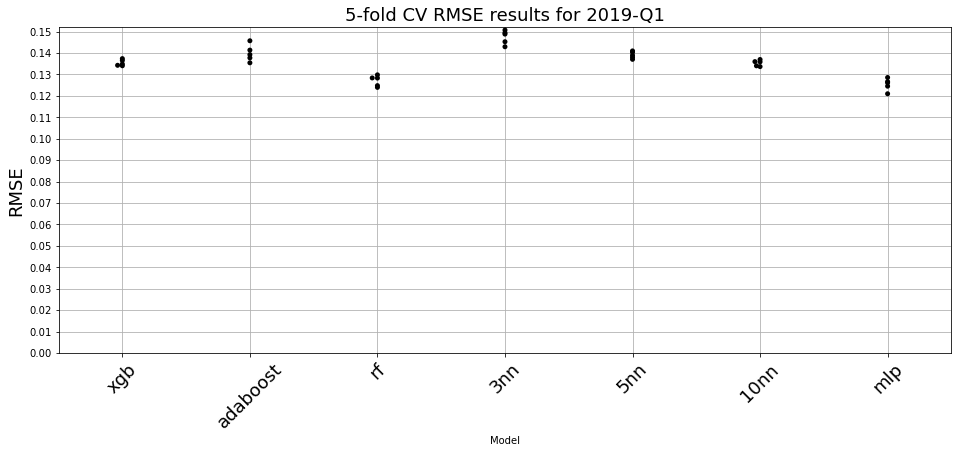

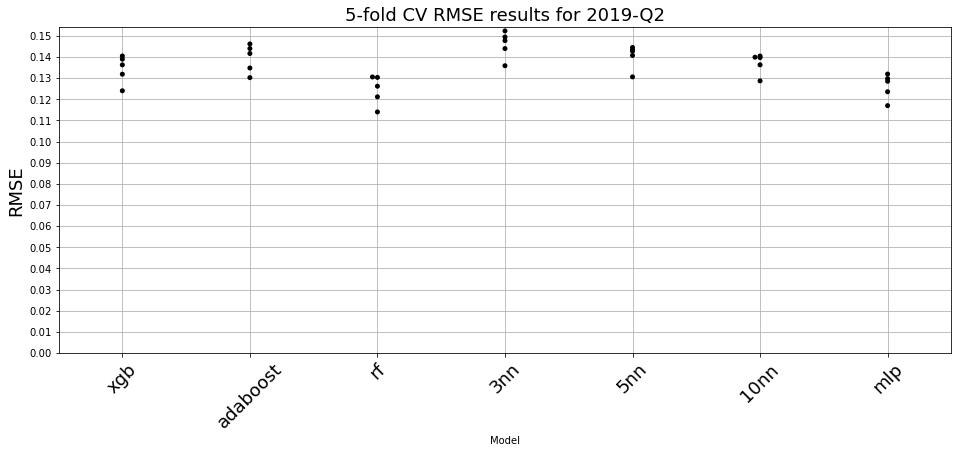

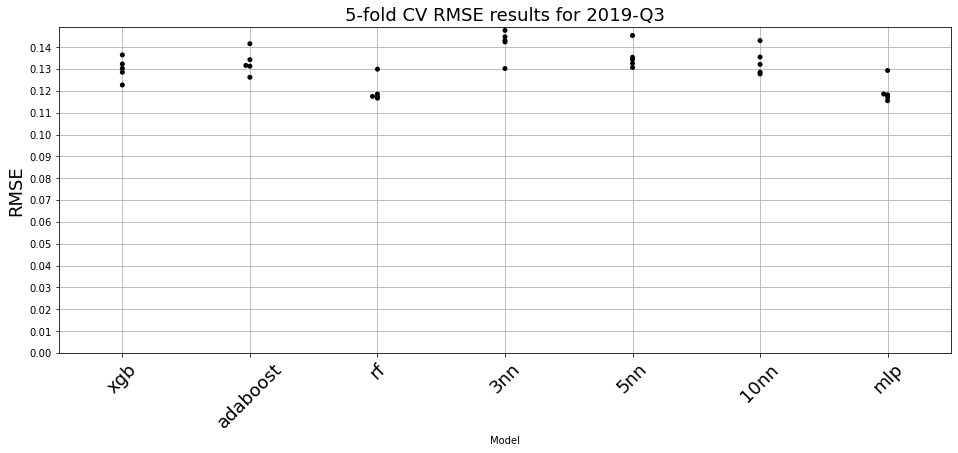

In [9]:
# define a data frame to register the votes for best kfold model for every quarter
best_Q_model_votes = pd.DataFrame(columns=list(ml_pool))

# instantiate kfold split 
skf = KFold(n_splits=5, shuffle=True, random_state=34)

# early stopping for the mlp
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', 
                                      min_delta=1e-5, patience=15, restore_best_weights=True)
# a counter for quarters
i = 0
for year in np.sort(train_df['Year'].unique()):
    
    for quarter in np.sort(train_df['Quarter'].unique()):
        
        # if data for the year and quarter is not available (this happens with the first and last year because not all their quarters are available)
        if str(year)+'-'+str(quarter) not in Quarterly_train_data:
            continue
        # grab the data for this specific 'Quarter' of this specific 'Year'
        temp_data = Quarterly_train_data[str(year)+'-'+str(quarter)]
        
        cols = temp_data.columns
        X_data = temp_data[cols[1:]].values
        y_data = temp_data['TradePrice'].values
        
        # fold number
        fold_num = 0
        # a dataframe to store the performans of models for every fold
        eval_df = pd.DataFrame(columns=list(ml_pool))
        # a list to store model name, fold number, and evaluation results for plotting
        eval_plot_list = []
        # run kfold cv
        for train_fold, test_fold in skf.split(X_data, y_data):
            # grab X_train_fold, X_test_fold and y_train_fold, y_test_fold
            X_train_fold, X_test_fold = X_data[train_fold], X_data[test_fold]
            y_train_fold, y_test_fold = y_data[train_fold], y_data[test_fold]
            
            # rescale
            SC = MinMaxScaler()
            SC.fit(X_train_fold)
            X_train_fold = SC.transform(X_train_fold)
            X_test_fold = SC.transform(X_test_fold)

            SC_y = MinMaxScaler()
            SC_y.fit(y_train_fold.reshape(len(y_train_fold),1))
            y_train_fold = SC_y.transform(y_train_fold.reshape(len(y_train_fold),1))
            y_test_fold = SC_y.transform(y_test_fold.reshape(len(y_test_fold),1))
            
            # a list to store the evaluation results for every model in a specific fold 
            fold_eval = []
            # train/test fold models 
            for model in ml_pool: 
                
                # the mlp requires a special treatment
                if model == 'mlp':
                    fold_model = ml_pool[model](shape=X_train_fold.shape)
                    fold_model.fit(X_train_fold, y_train_fold, batch_size=30, verbose=0, epochs=150, 
                    validation_split=0.2, callbacks=[es])
                    y_pred_on_test_fold = fold_model.predict(X_test_fold)
                else: 
                    fold_model = ml_pool[model].fit(X_train_fold,y_train_fold.flatten())
                    y_pred_on_test_fold = fold_model.predict(X_test_fold)
                
                # evaluate 
                rmse = MSE(y_test_fold, y_pred_on_test_fold,squared =False)
                # save the evaluation results for a specific model
                fold_eval.append(rmse)
                eval_plot_list.append([model, fold_num] + [rmse])
            # update fold number 
            fold_num+=1                
            
        # create eval_plot_df from eval_results
        plot_columns=['Model', 'Fold Number', 'RMSE']
        eval_plot_df = pd.DataFrame(data=eval_plot_list, columns = plot_columns)
        # plot 
        fig, ax = plt.subplots(figsize=(16, 6))

        sns.swarmplot(x="Model", y='RMSE', data=eval_plot_df, color = 'k',label='RMSE')

        ax.set_title('5-fold CV RMSE results for '+str(year)+'-Q'+str(quarter),fontsize=18)
        ax.set_ylabel('RMSE',fontsize=18)
        ax.yaxis.set_major_locator(MultipleLocator(0.01))
        plt.ylim(0)
        plt.xticks(rotation=45)
        ax.tick_params(axis='x', which='major', labelsize=18)
        plt.grid()
        plt.show()
        
        # save the evaluation results for a specific fold 
        eval_df.loc[fold_num] = fold_eval
        # get the mean RMSE for the 5 folds 
        mean_rmse = eval_df.mean(axis=0)
        # find the index of the best model
        best_model_index = np.where(mean_rmse==np.min(mean_rmse))
        # create a zeros row
        votes_row = np.zeros(len(mean_rmse))
        # put a 1 at the index of the best model (i.e. vote for best model)
        votes_row[best_model_index] = 1
        # append the row to the 'best_Q_models' dataframe
        best_Q_model_votes.loc[i] = votes_row
        i+=1

#### Find the best model based on votes of each quarter:

In [10]:
pd.DataFrame([best_Q_model_votes.sum(axis=0).values], columns = list(ml_pool),index=['Votes']).astype(int)

,xgb,adaboost,rf,3nn,5nn,10nn,mlp
Votes,0,0,40,0,0,0,17


Based on the votes of each quarter, the most suited model is RandomForest 

#### Model every qurter set independently using the candidate model and the full training set.

In [9]:
# to save trained models and fitted scalers of every quarter
models = {}
scalers = {}

# to store evaluation of every quarter model
rmse_list = []
mae_list = []
mape_list = []

for year in np.sort(train_df['Year'].unique()):
    
    for quarter in np.sort(train_df['Quarter'].unique()):
        
        # if data for the year and quarter is not available (this happens with the first and last year because not all their quarters are available)
        if str(year)+'-'+str(quarter) not in Quarterly_train_data:
            continue
        
        # grab the data for this specific 'Quarter' of this specific 'Year'
        train_data = Quarterly_train_data[str(year)+'-'+str(quarter)]
        test_data = Quarterly_test_data[str(year)+'-'+str(quarter)]
        
        # get train/test entries 
        cols = train_data.columns
        X_train_Q = train_data[cols[1:]].values
        y_train_Q = train_data['TradePrice'].values
        X_test_Q = test_data[cols[1:]].values
        y_test_Q = test_data['TradePrice'].values
        
        # rescale 
        SC = MinMaxScaler()
        SC.fit(X_train_Q)
        X_train_Q = SC.transform(X_train_Q)
        X_test_Q = SC.transform(X_test_Q)
        
        SC_y = MinMaxScaler()
        SC_y.fit(y_train_Q.reshape(len(y_train_Q),1))
        y_train_Q = SC_y.transform(y_train_Q.reshape(len(y_train_Q),1))
        y_test_Q = SC_y.transform(y_test_Q.reshape(len(y_test_Q),1))
        
        # save the scalers
        scalers[str(year)+'-'+str(quarter)] = {'SC':SC, 'SC_y':SC_y}
        
        # model 
        model = RandomForestRegressor(n_estimators=300, max_features='log2',random_state=34)
        model = model.fit(X_train_Q, y_train_Q.flatten())
        # save the trained model
        models[str(year)+'-'+str(quarter)] = model
        
        # predict the test set
        y_pred_on_test = model.predict(X_test_Q)
        
        # save evaluation
        rmse_list.append(MSE(y_test_Q, y_pred_on_test,squared =False))
        mae_list.append(MAE(y_test_Q, y_pred_on_test))
        # inverse scale y_pred_on_test & y_test_Q before calculating the MAPE
        y_pred_on_test = SC_y.inverse_transform(y_pred_on_test.reshape(len(y_pred_on_test),1))
        y_test_Q = SC_y.inverse_transform(y_test_Q)
        mape_list.append(MAPE(y_test_Q,y_pred_on_test))
        print('Model '+str(year)+'-'+str(quarter)+' Done')

Model 2005-3 Done
Model 2005-4 Done
Model 2006-1 Done
Model 2006-2 Done
Model 2006-3 Done
Model 2006-4 Done
Model 2007-1 Done
Model 2007-2 Done
Model 2007-3 Done
Model 2007-4 Done
Model 2008-1 Done
Model 2008-2 Done
Model 2008-3 Done
Model 2008-4 Done
Model 2009-1 Done
Model 2009-2 Done
Model 2009-3 Done
Model 2009-4 Done
Model 2010-1 Done
Model 2010-2 Done
Model 2010-3 Done
Model 2010-4 Done
Model 2011-1 Done
Model 2011-2 Done
Model 2011-3 Done
Model 2011-4 Done
Model 2012-1 Done
Model 2012-2 Done
Model 2012-3 Done
Model 2012-4 Done
Model 2013-1 Done
Model 2013-2 Done
Model 2013-3 Done
Model 2013-4 Done
Model 2014-1 Done
Model 2014-2 Done
Model 2014-3 Done
Model 2014-4 Done
Model 2015-1 Done
Model 2015-2 Done
Model 2015-3 Done
Model 2015-4 Done
Model 2016-1 Done
Model 2016-2 Done
Model 2016-3 Done
Model 2016-4 Done
Model 2017-1 Done
Model 2017-2 Done
Model 2017-3 Done
Model 2017-4 Done
Model 2018-1 Done
Model 2018-2 Done
Model 2018-3 Done
Model 2018-4 Done
Model 2019-1 Done
Model 2019

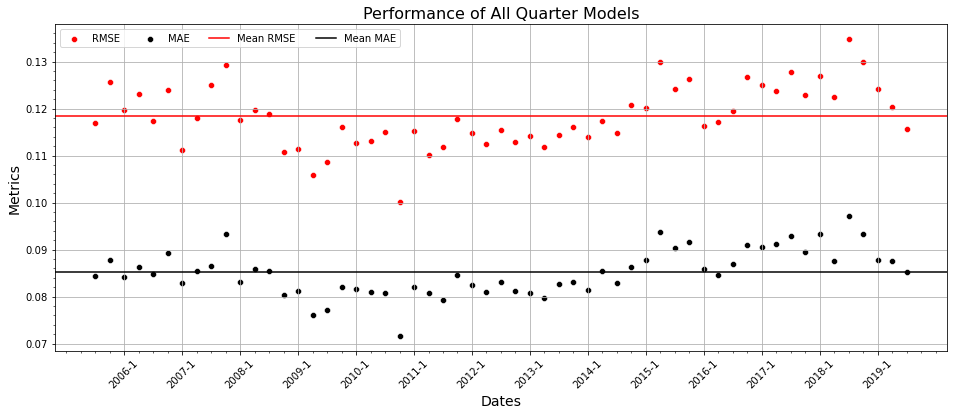

In [10]:
# plot performance with respect to time
eval_dict = {'Dates':models.keys(),'RMSE':rmse_list,'MAE':mae_list,'MAPE':mape_list}
eval_df = pd.DataFrame(eval_dict)

dates = eval_df.index
fig, ax = plt.subplots(figsize=(16,6))
sns.scatterplot(x='Dates',y = 'RMSE', data=eval_df, color='r', label = 'RMSE')
sns.scatterplot(x='Dates',y = 'MAE', data=eval_df, color='k', label = 'MAE')
# sns.scatterplot(x='Dates',y = 'MAPE', data=eval_df, color='gray', label = 'MAPE')
ax.set_title('Performance of All Quarter Models',fontsize=16)
ax.set_ylabel('Metrics',fontsize=14)
ax.set_xlabel('Dates',fontsize=14)
ax.yaxis.set_major_locator(MultipleLocator(0.01)) 
plt.axhline(y=eval_df['RMSE'].mean(),color='r',label='Mean RMSE')
plt.axhline(y=eval_df['MAE'].mean(),color='black',label='Mean MAE')

plt.minorticks_on()
plt.xticks(np.arange(2, len(dates-2), step=4),rotation=45)
plt.grid()
plt.legend(loc='upper left',ncol=4)
plt.show()


<a id='Destination_4'></a>


#  4. LSTM Time Series Modeling

- define a function "predict_time_series" that takes in an instance X and the trained quarter models and the fitted scalers dictionary. the function returns the inverse scaled price prediction of X from every quarter model.
- take a sample X from the test set "test_df" and predict the price time series.
- model the predicted time series using an LSTM with 10-folds cv.
- report the performance of the 10-folds models.
- generate a plot of the predicted price and forecast the future prices.
- generate R2 plot of the model.

In [11]:
def predict_time_series(models,X, scalers):
    
    scaled_x_vec= {key:scale['SC'].transform(X) for key,scale in scalers.items()}
    
    
    y_pred=[]
    
    for model in models:
        y_pred.append(models[model].predict(scaled_x_vec[model]))
   
    y_pred=np.array(y_pred).reshape((len(y_pred),1)) 
    inv_y_pred=[]
    
    i=0
    for key,scale in scalers.items():
        
        inv_y_pred.append(scale['SC_y'].inverse_transform(y_pred[i].reshape(1,1))) 
        i+=1
    
    return np.array(inv_y_pred).flatten()

In [12]:
# take X from the test set (drop Year, Quarter, and TradePrice because they are not features of the models)
X=test_df.loc[0].drop(['Year','Quarter','TradePrice']).values.reshape(1,10)
X

array([[50, 3.0, 99.7, 36100000.0, 33552446.48318043, 35419112.62798635,
        33980235.294117644, 1, 5, 817]], dtype=object)


#### 10-Folds LSTM model  Definitions

In [40]:
def prepare_data_folds(data,seed, n_past, n_future,kfolds):

#this function takes in time series data and prepare the input shape for the LSTM based on the number of past instances,
#the user want to consider

#n_past: the number of past instances to consider for prediction
#n_future: the number of time step gaps between past instances and predicted output.
#seed: random seed
#kfolds: the number of folds to prepare

#the function returns the prepare data folds, and prepared data with time sequance preserved
#plus the fitted scalers for every folds and the random indecies of every folds (the indecies are used to track the folds in late steps)
    
    np.random.seed(seed)
    rand_index = np.random.permutation(range(data.shape[0]-n_past)) 

    fold_indecies = np.array_split(rand_index,kfolds)
    
    scalers = {}
    data_folds = {}
    time_seq_data = {}
    for k in range(kfolds):
        
        SC = MinMaxScaler()
        SC = SC.fit(np.delete(data,fold_indecies[k],axis=0))
        scaled_data = SC.transform(data)
        SC_y = MinMaxScaler()
        SC_y = SC_y.fit(np.delete(data[:,0:1],fold_indecies[k],axis=0))
                        
        scalers[str(k)] = {'SC':SC, 'SC_y':SC_y}
                        
        # construct input/output for LSTM
        x_data = np.zeros((scaled_data.shape[0]-n_past, n_past, scaled_data.shape[1]))
        y_data = np.zeros((scaled_data.shape[0]-n_past, scaled_data.shape[1]))

        j=n_past
        for i in range(x_data.shape[0]):
            x_data[i] = scaled_data[j-n_past:j,:]
            y_data[i] = scaled_data[j+n_future-1: j+n_future]
            j+=1

        x_train = np.delete(x_data,fold_indecies[k],axis=0)
        x_test = x_data[fold_indecies[k]]
        y_train = np.delete(y_data,fold_indecies[k],axis=0)
        y_test = y_data[fold_indecies[k]]
                        
        data_folds[str(k)] = {'x_train':x_train,'x_test':x_test,
                              'y_train':y_train, 'y_test':y_test}
        time_seq_data[str(k)] = {'x_data':x_data, 'y_data':y_data}
                        
    return data_folds, time_seq_data, scalers, fold_indecies

def compile_LSTM(shape, summary=False):
# a function it takes in the input shape and return a compiled LSTM

    tf.random.set_seed(34)
    model = keras.Sequential(
        [
            layers.LSTM(units =24, input_shape=(shape), 
                   activation = 'relu', return_sequences=True),
            layers.LSTM(units =24, activation = 'relu', return_sequences=False),
            layers.Dense(activation='relu',units=1)
        ]
    )
    model.compile(optimizer = 'adam' , loss='mse')
    if summary:
        model.summary()
    return model

def train_test_LSTM(x_train, x_test, y_train, y_test,scaler):
    
#a function takes in data and scalers
#train and test an LSTM model
#the function returns the trained model, and the model history, and the test result

    # Compile and fit LSTM
    LSTM_model = compile_LSTM(shape = x_train.shape[1:], summary=False)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='rmse', mode='auto', 
                                               min_delta=1e-7, patience=10, restore_best_weights=True)
    history = LSTM_model.fit(x_train,y_train, shuffle = False, epochs = 100,validation_split=0.2,
                        callbacks = [es], verbose=0,batch_size = 3)
    
    # Test results 
    y_pred = LSTM_model.predict(x_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)
    test_res = {'RMSE':MSE(y_test,y_pred,squared=False), 'MAE':MAE(y_test,y_pred), 'MAPE':MAPE(y_test_inv,y_pred_inv)}
    
    return LSTM_model , history, test_res

def forecast(x_data, y_data, scales, LSTM_model):
# a function that takes in data and scalers plus model
#X_data & y_data: are not shuffled (the time sequance is preserved)
# the function returns the predicted output plus the forecast result.

    # Forecast results
    y_pred = LSTM_model.predict(x_data)
    forecast_res = {'RMSE':MSE(y_data, y_pred, squared=False), 
                    'MAE':MAE(y_data, y_pred),
                    'MAPE':MAPE(y_data, y_pred)}
    y_pred = scales['SC_y'].inverse_transform(y_pred)

    return y_pred, forecast_res

def generate_dates(start_stamp,n_dates):
# a function that takes in a start time stamp and return a data frame of n future time stamps
# n_dates: the number of future time stamps.

    start = int(start_stamp[:4])
    years = np.arange(start,start+int(n_dates/4)+1+n_dates%4)
    Qs = np.arange(1,5)
    dates = pd.DataFrame(columns=['Date'])
    end_Q = n_dates%4
    if int(start_stamp[-1])<4:
        Q = int(start_stamp[-1])+1
        while Q<=4:
            date = pd.Series(str(years[0])+'-'+str(Q))
            dates = pd.concat([dates,date],axis=0)
            Q+=1

    for year in years[1:]:
        for Q in Qs: 
            date = pd.Series(str(year)+'-'+str(Q))
            if dates.shape[0]==n_dates:
                dates.loc[:,'Date'] = dates.loc[:,0]
                return dates[['Date']].reset_index(drop=True)
            else:
                dates = pd.concat([dates,date],axis=0)

def forecast_summary(time_series, dates, y_pred,n_past,n_future):
    
#a function that takes in the original time series, and LSTM predicted values plus n_past and n_future parameters of LSTM.
#the function generate price forecast plot plus the R2 plot, in addition to the inversed scaled performance metrics.
 
    future_dates = generate_dates(start_stamp=dates.values[-1],n_dates=n_future)
    dates = pd.concat([dates,future_dates['Date']],axis=0).values
    print("Performance results on forecast:")
    print("     RMSE = "+format(MSE(time_series[n_past:], y_pred[:-n_future], squared=False),".4f"))
    print("     MAE = "+format(MAE(time_series[n_past:], y_pred[:-n_future]),".4f"))
    print("     MAPE = "+format(MAPE(time_series[n_past:], y_pred[:-n_future]),".4f"))
    fig, ax = plt.subplots(figsize=(16,6))
    ax.set_title('Real Price and Predicted Price Series')
    ax.set_ylabel('Trade Price',fontsize=14)
    plt.bar(dates[n_past:-n_future],time_series[n_past:].flatten(),color='k', width= 0.8, label = 'Original values')
    plt.bar(dates[n_past:], y_pred.flatten(), color='gray', width = 0.4, label = 'Predicted values')
    for date in dates[n_past:]:
        if date[-1]=='1':
            i = np.where(dates[n_past:]==date)[0]
            break
    plt.xticks(np.arange(i, len(dates[n_past:]), step=4),rotation=45)
    plt.minorticks_on()
    ax.yaxis.set_major_locator(MultipleLocator(2e6))
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.f'))
    plt.grid(axis='y')
    plt.legend(prop={'size': 16},ncol=2,loc='lower right')
    plt.show()
    
    # R2 plot
    r2 = r2_score(time_series[n_past:],y_pred[:-n_future])

    fig, ax = plt.subplots(figsize=(20,8))

    plt.scatter(time_series[n_past:],y_pred[:-n_future],marker='s',color = 'gray',label = 'R2 = '+format(r2,'.4f'))
    plt.plot(time_series[n_past:], time_series[n_past:].flatten(), color = 'k', label = 'True TradePrice')
    ax.set_title('Scatter plot of true vs. predicted values, test_size='+str(len(y_pred[:-n_future])),fontsize=16)
    ax.set_ylabel('Predicted TradePrice',fontsize=14)
    ax.set_xlabel('True TradePrice',fontsize=14)
    plt.grid()
    plt.legend(prop={'size': 16})
    plt.show()
    


## 10-fold LSTM modeling

- predict the time series of static models.
- prepare 10 data folds.
- develop 10-folds models.
- predict prices qith time sequance preserved.
- report performance.
- generate forecast plots.


In [14]:
#predict time series for X
time_series = predict_time_series(models,X, scalers)
time_series = time_series.reshape(len(time_series),1)

In [15]:
#prepare data folds
n_past=4
n_future=1
kfolds=10
data_folds, time_seq_data, t_scalers, fold_indecies = prepare_data_folds(time_series,seed=34, n_past=n_past, n_future=n_future,kfolds=kfolds)

In [27]:
# run 10-folds modeling
t_models = {}
histories = {}
test_results = {}
n_forward = 25
y_pred_sum = np.zeros(time_seq_data[str(0)]['y_data'].shape)
y_future_sum = np.zeros((n_forward,time_seq_data[str(0)]['y_data'].shape[1]))

for k in range(kfolds):
    # get train/test data    
    x_train = data_folds[str(k)]['x_train']
    x_test = data_folds[str(k)]['x_test']
    y_train = data_folds[str(k)]['y_train']
    y_test = data_folds[str(k)]['y_test']
    
    # train/test 
    LSTM_model , history, test_res =  train_test_LSTM(x_train, x_test, y_train, y_test,t_scalers[str(k)]['SC_y'])
    t_models[str(k)] = LSTM_model
    histories[str(k)] = history
    test_results[str(k)] = test_res
    
    #get the data with time sequance perserved
    x_data, y_data = time_seq_data[str(k)]['x_data'], time_seq_data[str(k)]['y_data']
    #forecast x_data to get y_pred
    y_pred, forecast_res = forecast(x_data, y_data, t_scalers[str(k)], t_models[str(k)])
    
    #prepare shape of input instances for future prediction
    x_future = np.zeros((n_forward+1,n_past,1))
    x_future[0] = y_data[-n_past:]
    y_future = y_data[-n_past+1:]
    for i in range(n_forward):
        future_pred = LSTM_model.predict(x_future[i:i+1]).reshape(1,1)
        y_future = np.concatenate((y_future,future_pred),axis=0)
        x_future[i+1] = y_future[-n_past:]
    
    #update the sum of forecasted future predictions
    y_future_sum+= t_scalers[str(k)]['SC'].inverse_transform(y_future[-n_forward:])
    #record the predicted y_pred to y_pred_sum using its specific indecies
    y_pred_sum[fold_indecies[k]] =  y_pred[fold_indecies[k]]
    print('Fold '+str(k)+' Done')
#take the mean of future predicted values (the prediction is the average of 10 model predictions)
y_future_final = y_future_sum/kfolds

1/1 [==============================] - 0s 15ms/step
Fold 0 Done
1/1 [==============================] - 0s 14ms/step
Fold 1 Done
1/1 [==============================] - 0s 15ms/step
Fold 2 Done
1/1 [==============================] - 0s 16ms/step
Fold 3 Done
1/1 [==============================] - 0s 15ms/step
Fold 4 Done
1/1 [==============================] - 0s 16ms/step
Fold 5 Done
1/1 [==============================] - 0s 15ms/step
Fold 6 Done
1/1 [==============================] - 0s 15ms/step
Fold 7 Done
1/1 [==============================] - 0s 15ms/step
Fold 8 Done
1/1 [==============================] - 0s 15ms/step
Fold 9 Done


In [37]:
#report the evaluaton for each fold
display(pd.DataFrame(test_results).T.round(4))
#report the mean evaluation
Mean_performance=pd.DataFrame(test_results).T.round(4).mean(axis=0)
pd.DataFrame(Mean_performance.values, columns=['Mean performance'],index=Mean_performance.index)

,RMSE,MAE,MAPE
0,0.1065,0.0906,0.0428
1,0.2815,0.1967,0.0812
2,0.0861,0.0753,0.0363
3,0.0887,0.0630,0.0293
4,0.0792,0.0723,0.0345
5,0.2350,0.1976,0.1101
6,0.2205,0.1388,0.0572
7,0.2446,0.2132,0.1037
8,0.1620,0.1273,0.0640
9,0.1514,0.1254,0.0630


,Mean performance
RMSE,0.16555
MAE,0.13002
MAPE,0.06221


Performance results on forecast:
     RMSE = 2868397.9262
     MAE = 2083040.0665
     MAPE = 0.0617


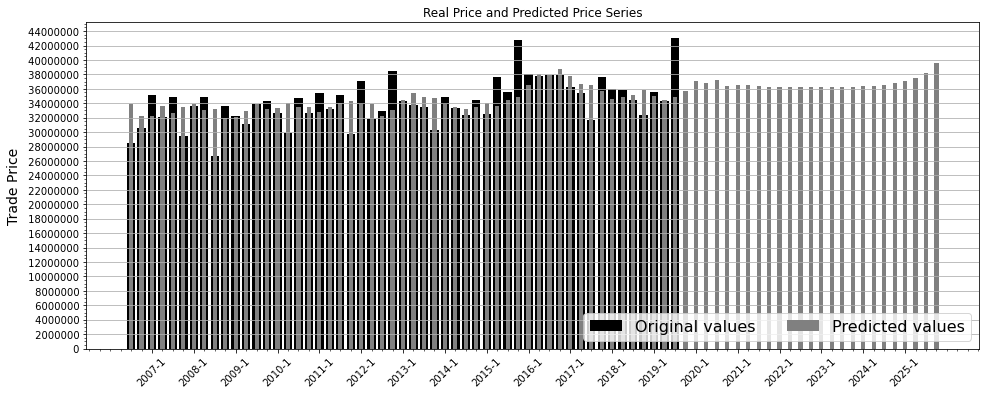

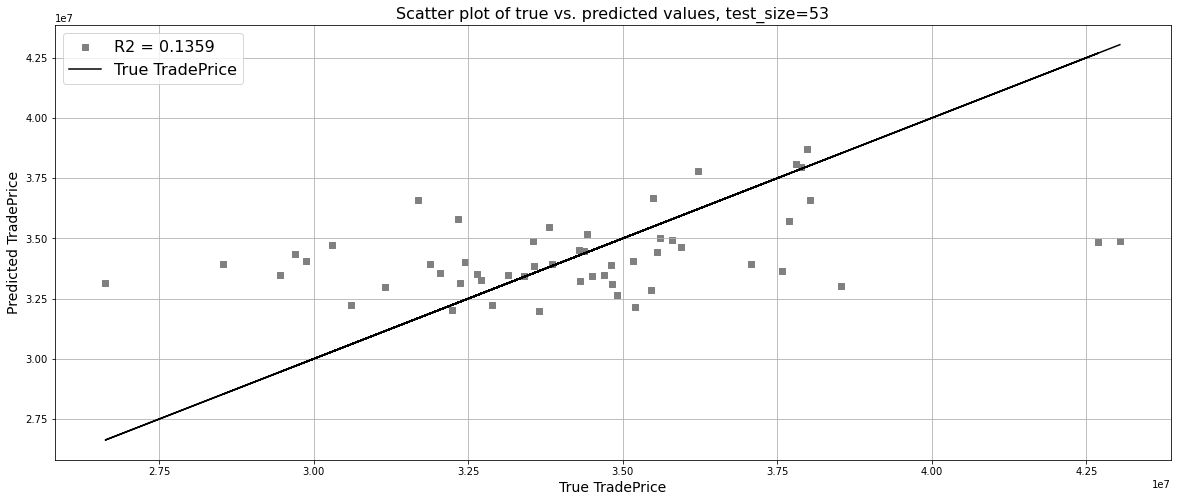

In [41]:
# generate forecast plots 
dates = eval_df['Dates']

forecast_summary(time_series, dates,  np.concatenate((y_pred_sum,y_future_final)),n_past =n_past,n_future=n_forward)

# 5. Conclusion

    In this work we developed static models for every quarter in the dataset. The static models are then used to predicit the price for a sample instance. The set of prediction of the static models constitutes a time series of price prediction for the sample instance. The time series is then modeled using an LSTM to forecast future prices. As evident from the plots, the method does not suit the problem. The main issue with this approach is that the time series prediction is based on a series of predicted values not actual values. This means that error is introduced before the LSTM modeling step. 